In [1]:
pip install xgboost --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install category_encoders

In [3]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [4]:
# --- Fonction pour le projet --- #

def cross_valid(X_train, y_train, X_test, y_test, preprocessor):
    '''
    Fonction pour effectuer une cross-validation sur plusieurs modèles et évaluer 
    leurs performances sur les données d'entraînement et de test.
    '''
    
    # Liste des modèles à tester
    liste = [
        DummyRegressor(strategy='mean'),   # Modèle de référence (baseline) : prédit toujours la moyenne des cibles
        LinearRegression(),               # Régression linéaire simple sans régularisation
        Ridge(),                          # Régression linéaire avec régularisation L2 pour éviter les coefficients trop grands
        Lasso(max_iter=20000, alpha = 100), # Régression linéaire avec régularisation L1 pour réduire à zéro les coefficients inutiles
        ElasticNet(max_iter=20000, alpha = 100), # Combine L1 et L2 pour un compromis entre parcimonie et limitation des coefficients
        RandomForestRegressor(random_state=42),  # Forêt aléatoire, basée sur des arbres de décision, efficace pour les relations complexes
        KNeighborsRegressor(),            # K-Nearest Neighbors : utilise la proximité des données pour faire des prédictions
        SVR(),                            # Support Vector Regressor : utilise des marges maximales pour la régression
        XGBRegressor()                    # Extreme Gradient Boosting : méthode puissante d'ensemble basée sur des arbres optimisés
    ]
    
    # Initialisation des listes pour stocker les résultats des différentes métriques pendant la validation croisée
    RMSE = []       # Root Mean Squared Error : racine de l'erreur quadratique moyenne (CV)
    R2 = []         # Coefficient de détermination R² (CV)
    MAE = []        # Mean Absolute Error : erreur absolue moyenne (CV)
    MedAE = []      # Median Absolute Error : erreur absolue médiane (CV)
    FIT_TIME = []   # Temps moyen d'entraînement pendant la cross-validation
    SCORE_TIME = [] # Temps moyen pour effectuer les prédictions pendant la cross-validation
    
    # Initialisation des listes pour les performances sur le jeu de test
    TEST_RMSE = []  # Erreur quadratique moyenne (racine) sur le jeu de test
    TEST_R2 = []    # Coefficient de détermination R² sur le jeu de test
    TEST_MAE = []   # Erreur absolue moyenne sur le jeu de test
    TEST_MedAE = [] # Erreur absolue médiane sur le jeu de test

    # Boucle pour tester chaque modèle dans la liste
    for model in liste:
        # Création d'un pipeline : 
        # - Applique d'abord le préprocesseur aux données (standardisation/encodage)
        # - Ensuite, ajuste le modèle spécifié
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        
        # Validation croisée (CV) pour évaluer les performances sur plusieurs partitions des données d'entraînement
        score = cross_validate(
            pipe,                         # Pipeline combinant préprocesseur et modèle
            X_train, y_train,             # Données d'entraînement
            cv=5,                         # Nombre de partitions (5-fold cross-validation)
            scoring=(                     # Métriques d'évaluation
                'neg_root_mean_squared_error',  # RMSE (retourné négatif par sklearn, d'où le besoin d'inverser le signe)
                'r2',                          # Coefficient de détermination R²
                'neg_mean_absolute_error',     # MAE (retourné négatif par sklearn)
                'neg_median_absolute_error'    # MedAE (retourné négatif par sklearn)
            ),
            return_train_score=False      # Ne pas inclure les scores sur le jeu d'entraînement
        )
        
        # Moyenne des résultats obtenus sur les 5 partitions (folds)
        rmse = score['test_neg_root_mean_squared_error'].mean()  # Moyenne des RMSE
        r2 = score['test_r2'].mean()                            # Moyenne des R²
        mae = score['test_neg_mean_absolute_error'].mean()      # Moyenne des MAE
        medae = score['test_neg_median_absolute_error'].mean()  # Moyenne des MedAE
        fit_time = score['fit_time'].mean()                     # Temps moyen d'entraînement
        score_time = score['score_time'].mean()                 # Temps moyen de prédiction

        # Entraîner le pipeline complet sur tout le jeu d'entraînement
        pipe.fit(X_train, y_train)
        
        # Faire des prédictions sur le jeu de test
        y_pred_test = pipe.predict(X_test)
        
        # Calcul des métriques sur le jeu de test
        test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)  # RMSE sur le test
        test_r2 = r2_score(y_test, y_pred_test)                            # R² sur le test
        test_mae = mean_absolute_error(y_test, y_pred_test)                # MAE sur le test
        test_medae = median_absolute_error(y_test, y_pred_test)            # MedAE sur le test

        # Stocker les résultats dans les listes correspondantes
        RMSE.append(-rmse)  # RMSE, inversé pour avoir une valeur positive
        R2.append(r2)       # Coefficient R²
        MAE.append(-mae)    # MAE, inversé pour avoir une valeur positive
        MedAE.append(-medae)# MedAE, inversé pour avoir une valeur positive
        FIT_TIME.append(fit_time)       # Temps moyen d'entraînement
        SCORE_TIME.append(score_time)   # Temps moyen de prédiction
        TEST_RMSE.append(test_rmse)     # RMSE sur le jeu de test
        TEST_R2.append(test_r2)         # R² sur le jeu de test
        TEST_MAE.append(test_mae)       # MAE sur le jeu de test
        TEST_MedAE.append(test_medae)   # MedAE sur le jeu de test
    
    # Création d'un tableau (DataFrame pandas) pour rassembler tous les résultats
    resultats = pd.DataFrame({
        'RMSE': RMSE,             # Résultats RMSE en CV
        'R2': R2,                 # Résultats R² en CV
        'MAE': MAE,               # Résultats MAE en CV
        'MedAE': MedAE,           # Résultats MedAE en CV
        'FIT_TIME': FIT_TIME,     # Temps moyen d'entraînement en CV
        'SCORE_TIME': SCORE_TIME, # Temps moyen de prédiction en CV
        'TEST_RMSE': TEST_RMSE,   # RMSE sur le jeu de test
        'TEST_R2': TEST_R2,       # R² sur le jeu de test
        'TEST_MAE': TEST_MAE,     # MAE sur le jeu de test
        'TEST_MedAE': TEST_MedAE  # MedAE sur le jeu de test
    })
    
    # Nommer les lignes pour indiquer quel modèle correspond à chaque ligne
    resultats.index = ['dum', 'lr', 'ridge', 'lasso', 'ElasticNet', 'RandomForest',
                       'KNR', 'SVR', 'XGBR']
    
    # Retourner le tableau des résultats pour analyse
    return resultats

def metrics_one(grid):
    res = pd.DataFrame(grid['grid_search'].cv_results_).sort_values('rank_test_r2')
    print('Meilleurs paramètres',grid['grid_search'].best_params_)
    print('Meilleur score RMSLE :',np.mean(res[res['rank_test_neg_mean_squared_log_error']==1]['mean_test_neg_mean_squared_log_error']))
    print('Meilleur score RMSE :',np.mean(res[res['rank_test_neg_root_mean_squared_error']==1]['mean_test_neg_root_mean_squared_error']))
    print('Meilleur score R2 :',grid['grid_search'].best_score_)
    print("Résultats des meilleurs paramètres :\n")
    display(res.loc[res['params']==grid['grid_search'].best_params_])
    
    return res

def bar_plot_compare(df, colonnes, neg=False):
    ''' Affiche des bar plots pour chaque variable renseignée en les triant en ordre croissant. '''
    fig, axes = plt.subplots(nrows=1, ncols=len(colonnes), figsize=(15, 6))  # Un seul rang de graphiques
    axes = axes.flatten()  # Transformer en liste pour faciliter l'itération

    for i, col in enumerate(colonnes):
        sorted_df = df.sort_values(by=col, ascending=True)  # Trier les valeurs
        
        if neg:
            sns.barplot(x=sorted_df["Modèle"], y=-1 * sorted_df[col], ax=axes[i])
        else:
            sns.barplot(x=sorted_df["Modèle"], y=sorted_df[col], ax=axes[i])
        
        axes[i].set_title(col)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")  # Rotation pour lisibilité

    plt.tight_layout(pad=3)
    plt.show()

    
def metrics_pred(y_true, y_pred):
    '''Calcule les métriques'''
    rmsle = mean_squared_log_error(y_true= y_true, y_pred=y_pred)
    r2 =  r2_score(y_true= y_true, y_pred=y_pred)
    res = pd.DataFrame({'RMSLE': rmsle,'R2':r2},index=[0])
    return res

#Fonction pour évaluer les performances
def metrics_pred(y_true, y_pred):
    res = {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred)
    }
    return pd.DataFrame([res])  # Retourne un DataFrame pour affichage clair

#Fonction pour entraîner et tester un modèle
def test_model(model, model_name, X_train, y_train, X_test, y_test, preprocessor):
    """
    Fonction pour entraîner un modèle, prédire et évaluer les performances sur le jeu d'entraînement et de test.
    """
    #Création du pipeline avec preprocessing
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Appliquer le preprocessing
        ('model', model)  # Modèle ML
    ])

    #Entraînement du modèle
    pipeline.fit(X_train, y_train)

    #Prédictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    #Évaluation des performances
    res_train = metrics_pred(y_train, y_train_pred)
    res_test = metrics_pred(y_test, y_test_pred)

    print(f"Résultats pour {model_name} :")
    print("Comparaison des performances sur le jeu d'entraînement :")
    display(res_train)
    print("Comparaison des performances sur le jeu de test :")
    display(res_test)

    return res_train, res_test

def grid_search_cv(model, params, preprocessor):
    """
    Crée un pipeline avec un préprocesseur et une recherche d'hyperparamètres via GridSearchCV.

    Args:
        model: Modèle de régression à tester.
        params: Dictionnaire des hyperparamètres à tester.

    Returns:
        Un pipeline entraînable contenant le modèle optimisé.
    """
    
    grid = Pipeline([
        ('preprocessor', preprocessor),  #Préprocessor passé en paramètre
        ('grid_search', GridSearchCV(
            TransformedTargetRegressor(regressor=model, func=np.log, inverse_func=np.exp),
            param_grid=params,
            cv=5,
            scoring=('neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error', 
                     'neg_median_absolute_error', 'neg_mean_squared_log_error'),
            return_train_score=True,
            refit='r2',
            n_jobs=-1
        ))
    ])
    
    return grid

def metric(grid, X_test, y_test):
    """
    Affiche et retourne les résultats du GridSearchCV pour l'entraînement et le test.

    Args:
        grid: Pipeline contenant le GridSearchCV.
        X_test: Données de test.
        y_test: Cibles de test.

    Returns:
        Résultats du GridSearchCV sous forme de DataFrame.
    """
    
    res = pd.DataFrame(grid['grid_search'].cv_results_).sort_values('rank_test_r2')
    
    print(" Meilleurs paramètres :", grid['grid_search'].best_params_)
    print(" Meilleur score RMSE :", np.mean(res[res['rank_test_neg_root_mean_squared_error'] == 1]['mean_test_neg_root_mean_squared_error']))
    print(" Meilleur score R2 :", grid['grid_search'].best_score_)
    
    print("\n Évaluation sur le jeu de test :")
    y_pred = grid.predict(X_test)
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    print(f" MAE (Test) : {mean_absolute_error(y_test, y_pred)}")
    print(f" RMSE (Test) : {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print(f" R² (Test) : {r2_score(y_test, y_pred)}")
    
    return res

# Prédiction et modélisation pour la variable SiteEnergyUse(kBtu)

## Sommaire 

    1. Préparation des données
    2. Optimisation modèles
    3. Transformation
        3.1 Feature Engineering Manuel
        3.2 TargetEncoding
        3.3 Logarithmique
        3.4 Résultats
        3.5 Fine Tuning
    4. Features importance
    5. Impact Energy Score

In [5]:
#Import des différentes librairies poour le projet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV,learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_log_error,confusion_matrix, mean_squared_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, median_absolute_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate
from datetime import datetime
from category_encoders import TargetEncoder


import time

In [6]:
import warnings
#warnings.filterwarnings("always")  # Affiche tous les avertissements
warnings.filterwarnings('ignore')
#Désactivation des warnings de depreciations
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
#Import des données clean
data = pd.read_csv(r"C:\Users\Jonathan.Gourville\Downloads\data_clean.csv")

In [8]:
#Enregistrement du data dans une variable data_original
data_original = data.copy()

## 1.Préparation des données

In [9]:
data.head()

,OSEBuildingID,Neighborhood,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,...,TotalGHGEmissions,BuildingAge,ElectricityUse,SteamUse,NaturalGasUse,SteamUseMost,NaturalGasUseMost,ElectricityUseMost,ParkingRatioGFA,MoreThan1Building
0,1,DOWNTOWN,12,88434,Hotel,88434.0,None,0.0,None,0.0,...,249.98,89,True,True,True,False,False,True,0.000000,False
1,2,DOWNTOWN,11,103566,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,...,295.86,20,True,False,True,False,True,False,0.145453,False
2,3,DOWNTOWN,41,956110,Hotel,756493.0,None,0.0,None,0.0,...,2089.28,47,True,True,True,False,False,True,0.205748,False
3,5,DOWNTOWN,10,61320,Hotel,61320.0,None,0.0,None,0.0,...,286.43,90,True,True,True,False,False,True,0.000000,False
4,8,DOWNTOWN,18,175580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,...,505.01,36,True,False,True,False,True,False,0.353115,False


In [10]:
data.shape

(1477, 22)

In [11]:
data.columns

Index(['OSEBuildingID', 'Neighborhood', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
       'BuildingAge', 'ElectricityUse', 'SteamUse', 'NaturalGasUse',
       'SteamUseMost', 'NaturalGasUseMost', 'ElectricityUseMost',
       'ParkingRatioGFA', 'MoreThan1Building'],
      dtype='object')

In [12]:
data.dtypes

OSEBuildingID                        int64
Neighborhood                        object
NumberofFloors                       int64
PropertyGFATotal                     int64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseType        object
SecondLargestPropertyUseTypeGFA    float64
ThirdLargestPropertyUseType         object
ThirdLargestPropertyUseTypeGFA     float64
ENERGYSTARScore                    float64
SiteEnergyUse(kBtu)                float64
TotalGHGEmissions                  float64
BuildingAge                          int64
ElectricityUse                        bool
SteamUse                              bool
NaturalGasUse                         bool
SteamUseMost                          bool
NaturalGasUseMost                     bool
ElectricityUseMost                    bool
ParkingRatioGFA                    float64
MoreThan1Building                     bool
dtype: object

In [13]:
#Séparation des features et de la target pour l'analyse
X = data.copy().drop(['OSEBuildingID','SiteEnergyUse(kBtu)','TotalGHGEmissions','ENERGYSTARScore'], axis =1) #copie du data dans x, suppression des colonnes inutiles
y = data.copy()['SiteEnergyUse(kBtu)'] #target

Création d'un dataframe X contenant uniquement les variables explicatives (features), je supprimes les colonnes non nécassaires.

        OseBuildingId : clé unique, inutile pour l'entraînement de donées
        SiteEnergyUse : La target principale
        TotalGHGEmissions : l'autre target, cela évite de donnée au modéle des informations supp qui au premier modéle
        ENERGYSTARScore : Variable corréle négativement avec la target.

In [14]:
#Division du jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [15]:
#Séparations des colonnes pour aider au traitement spécifiques selon le type de données
quanti = X.select_dtypes(['int32','float64']).columns

quali = X.select_dtypes(['category','object','bool']).columns

In [16]:
#Normalisation des valeurs quantitatives avec un standardiseur
std_scaler = StandardScaler() #Centre les données(soustrait la moyenne) - Réduit leur échelle(divise l'écart-type)
#Instancie un encodeur pour les variables quali
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False) # Transforme chaque variable en une colonne binaire (0 ou 1)
#preprocessor récupere les transformation des colonnes, quanti est normalisé, et quali est encodé.
preprocessor = ColumnTransformer(transformers =[
    ('quanti',std_scaler,quanti),
    ('quali',ohe,quali)])

In [17]:
#Dimension du tableau retournant les données d'entrainement (features)
X_train.shape

(1181, 18)

In [18]:
#Dimension des données de test (features)
X_test.shape

(296, 18)

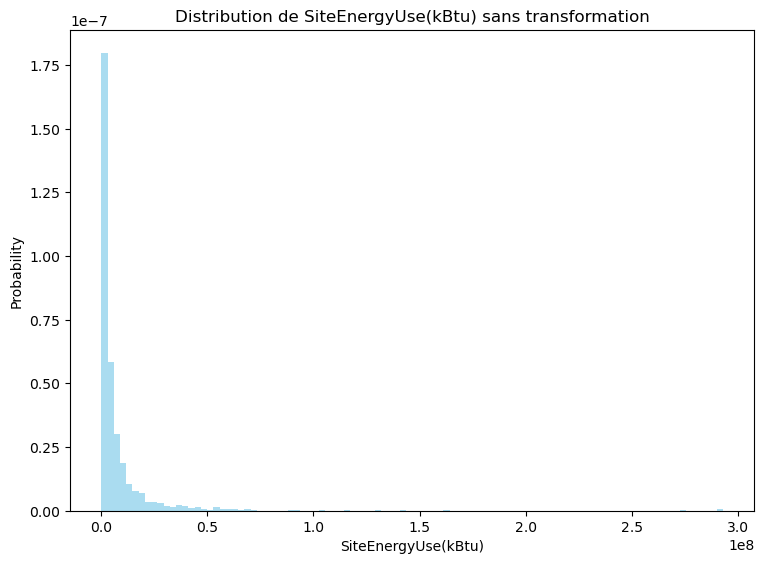

In [19]:
#Affichage de la distribution de la variable cible sans transformation
fig, ax0 = plt.subplots(figsize=(8, 6))

ax0.hist(y_train, bins=100, density=True, color='skyblue', alpha=0.7)
ax0.set_ylabel("Probability")
ax0.set_xlabel("SiteEnergyUse(kBtu)")
ax0.set_title("Distribution de SiteEnergyUse(kBtu) sans transformation")

plt.tight_layout(pad=2)
plt.show()

La variable suit une loi très asymétrique (une longue queue à droite ou gauche), une transformation logarithmique peut aider à rendre la distribution plus proche de la normale. Cela peut améliorer la performance de certains modèles comme la régression linéaire, qui est sensible à la non-normalité.

In [20]:
#Application de la transformation logarithmique sur y_train
y_train_log = np.log(y_train + 1)  # Ajoute 1 pour éviter log(0)

In [21]:
#J'applique aussi la transformation log sur y_test
y_test_log = np.log(y_test + 1)

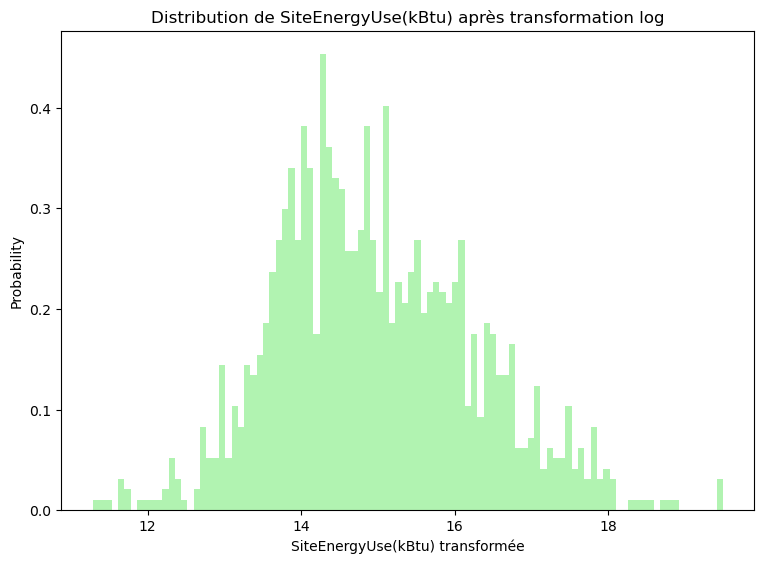

In [22]:
#Affichage de la distribution après transformation logarithmique
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.hist(y_train_log, bins=100, density=True, color='lightgreen', alpha=0.7)
ax1.set_ylabel("Probability")
ax1.set_xlabel("SiteEnergyUse(kBtu) transformée")
ax1.set_title("Distribution de SiteEnergyUse(kBtu) après transformation log")

plt.tight_layout(pad=2)
plt.show()

La cross-validation est une méthode cruciale pour évaluer la performance d'un modèle de manière robuste et fiable. Lorsque tu utilises plusieurs modèles dans une tâche de machine learning, faire une cross-validation pour chaque modèle présente plusieurs avantages.

Utilisation de cross validation sur plusieurs modèles qui permet de : 
                    
                    1.Évaluation fiable de la performance du modèle
                    2.Comparaison des modèles
                    3.Optimisation des hyperparamètres
                    4.Utiliser toute la donnée disponible pour l'entraînement
                    5.Choisir entre des modèles simples et complexes
                    6.Détection des biais

In [23]:
#Validation croisées sur plusieurs modéles de régression (calcul de divers métrique sur chaque modéle)
resultats = cross_valid(X_train, y_train, X_test, y_test, preprocessor)

Metriques utilisés : 
        
            1. RMSE (Root Mean Squared Error) : Racine carrée de l'erreur quadratique moyenne(MSE), mesure la dispersion des erreurs entre les prédictions et les valeurs réelles. PLUS RMSE est faible faible, MEILLEUR est le modèle. Proche de 0 -> prédictions proche des valeurs réelles
            2. R² (Coefficient de détermination) : mesure de la proportion de variance des données expliquée par le modèle. =1 explique toute la variance des données, =0 modéle ne fait pas mieux que prédire la moyenne de la cible, <0 moins performant qu'un modéle qui prédit la moyenne
            3.MAE (Mean Absolute Error) : mesure l'erreur absolue moyenne entre les valeurs prédites et les valeurs réelles. Calculé comme la moyenne des valeurs absolues des erreurs. Proche de 0 = prédictions proches des valeurs réelles, élevée = erreurs sont importantes en moyenne.
            4. MedAE (Median Absolute Error) : messure de l'erreur médiane absolue. Il est contraire à MAE, il mesure la médiane des erreurs absolues, donc plus robuste aux valeurs extrêmes d'un modéle. Valeur faible = erreurs petites, même si certaines sont grandes. Valeur élevée = certaines erreurs sont importantes et influencent le modèle. Proche de 0.
            5. FIT_TIME (Temps d'entraînement) : Temps que prend le modéle pour s'entrainer sur les données d'entraînement, cela dépend de la complexité, du nombre de données, de la puissance de calcul dispo: valeur faible à modérée : un modéle comme régression linéaire aura un temps faible mais XGBoost ou réseau de neurones plus long, élevé : modéle complexe ou grand jeu de données
            6.SCORE_TIME (Temps de prédiction) : mesure le temps que prend le modèle pour faire des prédictions sur les données de test.  Regréssion linéaire temps faible, RandomForest temps plus long. Trop élevée rend le modéle impratique en prod.
            
Les résultats concernent le jeu d'entraînement et de test.             

In [24]:
resultats

,RMSE,R2,MAE,MedAE,FIT_TIME,SCORE_TIME,TEST_RMSE,TEST_R2,TEST_MAE,TEST_MedAE
dum,1.833442e+07,-1.098478e-02,8.639004e+06,6.393569e+06,0.007976,0.004402,3.139952e+07,-1.462396e-05,9.484987e+06,6.468206e+06
lr,1.772090e+17,-1.505454e+20,3.082616e+16,2.567606e+06,0.023257,0.005401,2.126932e+17,-4.588468e+19,2.209855e+16,2.353255e+06
ridge,1.217455e+07,4.995258e-01,5.085460e+06,2.487480e+06,0.012825,0.004701,2.372583e+07,4.290430e-01,5.438513e+06,2.482087e+06
lasso,1.385969e+07,2.144074e-01,5.239930e+06,2.429590e+06,0.083740,0.005709,2.384370e+07,4.233561e-01,5.469853e+06,2.296721e+06
ElasticNet,1.799651e+07,3.095789e-02,8.400071e+06,6.196591e+06,0.010792,0.004807,3.098274e+07,2.635658e-02,9.258136e+06,6.297966e+06
RandomForest,1.396091e+07,3.896967e-01,4.067905e+06,1.151467e+06,0.752969,0.014351,1.913724e+07,6.285342e-01,4.064812e+06,9.400924e+05
KNR,1.391161e+07,4.436273e-01,4.738389e+06,1.489817e+06,0.007103,0.009787,2.670934e+07,2.764196e-01,5.227595e+06,1.256802e+06
SVR,1.906579e+07,-1.033232e-01,6.838711e+06,1.895281e+06,0.059848,0.034863,3.188117e+07,-3.092911e-02,7.197457e+06,1.928323e+06
XGBR,1.196930e+07,5.787634e-01,3.907466e+06,1.224358e+06,0.089160,0.008031,2.150647e+07,5.308640e-01,4.219135e+06,1.113566e+06


**Interprétation des résultats :**
   
        1. DUM : très faible performance avec des résultats (RMSE, R², TEST_RMSE et TEST_R²) qui montrent de faible performance
        2. Linear Regression : Amélioration par rapport à la baseline mais reste encore loin d'une bonne performance. 
        3. Ridge Regression : Performance améliorée par rapport à la régression linéaire simple.
        4. Lasso Regression : Elle ne surpasse pas la regréssion RIDGE
        5. ElasticNet : En retrait par rapport à Ridge
        6. RandomForest : Performant sur le CV (cross_valideation), mais perd en précision sur le jeu de test.
        7. KNR : Moins performant que RandomForest et Ridge
        8. SVR : Pas pertinant ici. Peut etre a cause de l'hyperparamètres ou les données.
        9. XGBR : Modèle plus performant, tant en termes de RMSE que de R²

In [25]:
#On test sur les données log.
resultats_log = cross_valid(X_train, y_train_log, X_test, y_test_log, preprocessor)

In [26]:
resultats_log

,RMSE,R2,MAE,MedAE,FIT_TIME,SCORE_TIME,TEST_RMSE,TEST_R2,TEST_MAE,TEST_MedAE
dum,1.294570e+00,-2.266946e-03,1.041074e+00,0.919716,0.008112,0.005200,1.344608e+00,-1.898547e-02,1.075989e+00,0.893746
lr,1.992709e+10,-3.589160e+20,3.153734e+09,0.581150,0.014705,0.005582,5.950668e+10,-1.995757e+21,6.182668e+09,0.523613
ridge,8.668799e-01,5.481241e-01,6.671468e-01,0.539957,0.010239,0.005005,8.274747e-01,6.140903e-01,6.358015e-01,0.521511
lasso,1.294570e+00,-2.266946e-03,1.041074e+00,0.919716,0.009934,0.004993,1.344608e+00,-1.898547e-02,1.075989e+00,0.893746
ElasticNet,1.294570e+00,-2.266946e-03,1.041074e+00,0.919716,0.008308,0.004107,1.344608e+00,-1.898547e-02,1.075989e+00,0.893746
RandomForest,6.868745e-01,7.169790e-01,5.117151e-01,0.385949,0.526730,0.012626,7.145167e-01,7.122594e-01,5.320459e-01,0.411893
KNR,8.611934e-01,5.548620e-01,6.568038e-01,0.525552,0.007308,0.009313,8.618283e-01,5.813821e-01,6.667395e-01,0.512253
SVR,7.231556e-01,6.866816e-01,5.482316e-01,0.428160,0.055498,0.029742,7.050807e-01,7.198092e-01,5.260488e-01,0.411244
XGBR,6.770464e-01,7.240736e-01,5.051599e-01,0.368389,0.074141,0.007504,7.095100e-01,7.162778e-01,5.287953e-01,0.445771


**Interprétation des résultats :**

         1. DUM : Aucun pouvoir prédictif, prédiction constante
         2. Linear Regression : Bonne performance, amélioration significative.
         3. Ridge Regression : Légèrement meilleur que la linear.
         4. Lasso Regression : Résultats identiques à la baseline.
         5. ElasticNet : Performance limitées, meilleur que la baseline
         6. RandomForest : Très bonnes perf
         7. KNR : Performances correctes, mais inférieur à RandomForest
         8. SVR : Très bon modéle
         9. XGBR : Meilleur compromis RMSE et R², modéle performant et robuste.

Pour la suite je vais garder les données log pour les raisons suivantes : 

                1. Amélioration de la distribution cible : ici une variable asymétrique (SiteEnergyUse(kBtu)) sur laquelle la transformation logarithmique a permis d'avoir une distribution plus proche de la normale.
                2. Les valeurs de y_train, y_test  qui peuvent être aberrantes seront moins significatif avec une transformation logarithmique.
                3. Meilleur performance des modèles : les modèles montrent des résultats plus robustes (RMSE, R²,MAE, etc...) avec les données transformées. Le modèle XGBR a particulièrement montré une performance significative par rapport aux données non log. 
                4. Alignement avec les meilleures pratiques : dans de nombreux cas, quand la variable cible est non linéaire et fortement asymétrique, la transformation log est une étape importante pour améliorer les prédictions et performances du modèle.
                
Au vue des meilleurs résultats avec les données log, il est logique de gardé cette transformation pour les modéles finaux.

## 2.Optimisation modèles

In [27]:
#Liste des modèles à tester
models = {
    "DummyRegressor": DummyRegressor(),
    "LinearRegression": LinearRegression(fit_intercept=True, n_jobs=-1, positive=False),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "XGBRegressor": XGBRegressor(random_state=42)
}

#Stockage des résultats
results_train = {}
results_test = {}

#Boucle pour tester chaque modèle
for model_name, model in models.items():
    train_res, test_res = test_model(model, model_name, X_train, y_train, X_test, y_test, preprocessor)
    results_train[model_name] = train_res
    results_test[model_name] = test_res

Résultats pour DummyRegressor :
Comparaison des performances sur le jeu d'entraînement :


,MAE,MSE,RMSE,R²
0,8.636665e+06,3.886270e+14,1.971362e+07,0.0


Comparaison des performances sur le jeu de test :


,MAE,MSE,RMSE,R²
0,9.484987e+06,9.859298e+14,3.139952e+07,-0.000015


Résultats pour LinearRegression :
Comparaison des performances sur le jeu d'entraînement :


,MAE,MSE,RMSE,R²
0,3.874732e+06,8.384314e+13,9.156590e+06,0.784258


Comparaison des performances sur le jeu de test :


,MAE,MSE,RMSE,R²
0,2.209855e+16,4.523841e+34,2.126932e+17,-4.588468e+19


Résultats pour Ridge :
Comparaison des performances sur le jeu d'entraînement :


,MAE,MSE,RMSE,R²
0,4.097102e+06,8.801853e+13,9.381819e+06,0.773514


Comparaison des performances sur le jeu de test :


,MAE,MSE,RMSE,R²
0,5.438513e+06,5.629152e+14,2.372583e+07,0.429043


Résultats pour Lasso :
Comparaison des performances sur le jeu d'entraînement :


,MAE,MSE,RMSE,R²
0,3.874668e+06,8.384271e+13,9.156566e+06,0.784259


Comparaison des performances sur le jeu de test :


,MAE,MSE,RMSE,R²
0,5.482531e+06,5.686028e+14,2.384539e+07,0.423274


Résultats pour ElasticNet :
Comparaison des performances sur le jeu d'entraînement :


,MAE,MSE,RMSE,R²
0,4.984265e+06,1.919839e+14,1.385583e+07,0.505994


Comparaison des performances sur le jeu de test :


,MAE,MSE,RMSE,R²
0,5.756250e+06,6.505715e+14,2.550630e+07,0.340134


Résultats pour KNeighborsRegressor :
Comparaison des performances sur le jeu d'entraînement :


,MAE,MSE,RMSE,R²
0,3.728180e+06,1.217282e+14,1.103305e+07,0.686774


Comparaison des performances sur le jeu de test :


,MAE,MSE,RMSE,R²
0,5.227595e+06,7.133890e+14,2.670934e+07,0.27642


Résultats pour SVR :
Comparaison des performances sur le jeu d'entraînement :


,MAE,MSE,RMSE,R²
0,6.839537e+06,4.178088e+14,2.044037e+07,-0.075089


Comparaison des performances sur le jeu de test :


,MAE,MSE,RMSE,R²
0,7.197457e+06,1.016409e+15,3.188117e+07,-0.030929


Résultats pour RandomForestRegressor :
Comparaison des performances sur le jeu d'entraînement :


,MAE,MSE,RMSE,R²
0,1.352737e+06,2.101349e+13,4.584047e+06,0.945929


Comparaison des performances sur le jeu de test :


,MAE,MSE,RMSE,R²
0,4.064812e+06,3.662339e+14,1.913724e+07,0.628534


Résultats pour XGBRegressor :
Comparaison des performances sur le jeu d'entraînement :


,MAE,MSE,RMSE,R²
0,767828.861572,1.293728e+12,1.137422e+06,0.996671


Comparaison des performances sur le jeu de test :


,MAE,MSE,RMSE,R²
0,4.219135e+06,4.625284e+14,2.150647e+07,0.530864


In [28]:
#Créer une liste des résultats en DataFrame
df_train_results = pd.concat(results_train).reset_index(level=1, drop=True).reset_index()
df_test_results = pd.concat(results_test).reset_index(level=1, drop=True).reset_index()

#Renommer la colonne contenant le nom du modèle
df_train_results = df_train_results.rename(columns={'index': 'Modèle'})
df_test_results = df_test_results.rename(columns={'index': 'Modèle'})

#Ajouter une colonne pour identifier l'ensemble de données
df_train_results["Dataset"] = "Train"
df_test_results["Dataset"] = "Test"

#Fusionner les résultats
df_results_1 = pd.concat([df_train_results, df_test_results])

#Afficher le DataFrame final
df_results_1

,Modèle,MAE,MSE,RMSE,R²,Dataset
0,DummyRegressor,8.636665e+06,3.886270e+14,1.971362e+07,0.000000e+00,Train
1,LinearRegression,3.874732e+06,8.384314e+13,9.156590e+06,7.842581e-01,Train
2,Ridge,4.097102e+06,8.801853e+13,9.381819e+06,7.735141e-01,Train
3,Lasso,3.874668e+06,8.384271e+13,9.156566e+06,7.842592e-01,Train
4,ElasticNet,4.984265e+06,1.919839e+14,1.385583e+07,5.059944e-01,Train
5,KNeighborsRegressor,3.728180e+06,1.217282e+14,1.103305e+07,6.867736e-01,Train
6,SVR,6.839537e+06,4.178088e+14,2.044037e+07,-7.508947e-02,Train
7,RandomForestRegressor,1.352737e+06,2.101349e+13,4.584047e+06,9.459289e-01,Train
8,XGBRegressor,7.678289e+05,1.293728e+12,1.137422e+06,9.966710e-01,Train
0,DummyRegressor,9.484987e+06,9.859298e+14,3.139952e+07,-1.462396e-05,Test


Train set :

- DummyRegressor(MAE : 8.97e+06, RMSE : 2.42e+07, et R² : 0.000) : indique que ce modèle ne fait que prédire la moyenne des données et ne capture aucune information significative
- LineaRegression (MAE : 4.52e+06, RMSE : 1.10e+07, R² : 0.79), ce qui montre une bonne performance pour un modèle linéaire. Il explique environ 79.3% de la variance des données d'entraînement, ce qui est un bon résultat pour des relations linéaires
- Ridge(MAE : 4.68e+06, RMSE : 1.12e+07, R² : 0.785) ce modèle est très similaire à la régression linéaire mais avec un léger surcoût en termes d'MAE et RMSE 
- Lasso (MAE : 4.52e+06, RMSE : 1.10e+07, R² : 0.793) cette performance est similaire à celle de la régression linéaire
- ElasticNet(MAE : 5.20e+06, RMSE : 1.64e+07, R² : 0.540) ce modèle présente une baisse de performance importante par rapport aux autres modèles linéaires
- KNR(MAE : 3.95e+06, RMSE : 1.51e+07, R² : 0.610) ce modèle montre une performance raisonnable mais est moins performant que les modèles comme Random Forest ou XGBoost
- SVR(MAE : 6.98e+06, RMSE : 2.49e+07, R² : -0.0528) ce modèle a une très mauvaise performance
- RandomForest(MAE : 1.42e+06, RMSE : 5.58e+06, R² : 0.947) ce modèle donne des résultats excellents sur les données d'entraînement avec un R² très élevé. Cela montre qu'il est capable de bien s'adapter aux données.
- XGBRegressor(MAE : 8.42e+05, RMSE : 1.32e+06, R² : 0.997) ce modèle obtient une performance exceptionnelle, avec un R² très proche de 1, ce qui montre qu'il explique presque parfaitement les données d'entraînement.

Test set :

- DummyRegressor : MAE : 8.52e+06, RMSE : 1.40e+07, et R² : -0.0014, montrant que ce modèle continue à prédire la moyenne, mais avec une légère dégradation des performances sur le jeu de test.
- Linear Regression : MAE : 1.18e+16, RMSE : 7.11e+16, R² : -2.59e+19, des résultats catastrophiques. Ce modèle semble complètement sur-ajusté aux données d'entraînement (overfitting)
- Ridge : MAE : 4.79e+06, RMSE : 1.09e+07, R² : 0.389, une perte significative de performance par rapport à l'entraînement, mais encore une certaine capacité à expliquer la variance des données (R² relativement faible mais positif)
- Lasso : MAE : 4.87e+06, RMSE : 1.12e+07, R² : 0.358, similaire à Ridge, une perte notable de performance par rapport à l'entraînement, mais encore acceptable
- ElasticNet : MAE : 5.18e+06, RMSE : 1.10e+07, R² : 0.384, des résultats similaires à Lasso et Ridge, avec une perte de performance sur le jeu de test.
- KNeighborsRegressor : MAE : 5.07e+06, RMSE : 1.32e+07, R² : 0.112, ce modèle souffre d'un sur-apprentissage important, avec une performance dégradée sur le jeu de test
- SVR : MAE : 6.62e+06, RMSE : 1.49e+07, R² : -0.130, un modèle qui se comporte très mal sur le test, ce qui indique qu'il ne généralise pas bien
- RandomForestRegressor : MAE : 3.83e+06, RMSE : 1.21e+07, R² : 0.247, une perte de performance par rapport à l'entraînement, mais il reste relativement mieux que beaucoup d'autres modèles
- XGBRegressor : MAE : 3.60e+06, RMSE : 9.37e+06, R² : 0.550, un modèle qui souffre d'un sur-apprentissage. Bien que ses performances soient encore assez bonnes, le R² a chuté de manière significative par rapport à l'entraînement.

Conclusion : 

- XGBRegressor et RandomForestRegressor sont les modèles qui offrent les meilleures performances sur l'entraînement. Cependant, ils souffrent d'un sur-apprentissage (overfitting), comme en témoigne la dégradation de leur performance sur le jeu de test.
- Linear Regression, Ridge, et Lasso offrent un bon compromis, avec des résultats assez stables entre l'entraînement et le test, mais ne parviennent pas à atteindre des performances aussi élevées que les modèles d'arbres.
- SVR et KNeighborsRegressor montrent des performances médiocres tant sur l'entraînement que sur le test, ce qui indique qu'ils ne sont pas bien adaptés à ce type de données

In [29]:
def perform_grid_search_cv(grid_search_cv, metrics, X_train, y_train, X_test, y_test, preprocessor):
    """
    Effectue une recherche d'hyperparamètres pour plusieurs modèles en utilisant GridSearchCV.
    
    Args:
        grid_search_cv: Fonction qui crée et retourne un pipeline avec GridSearchCV.
        metrics: Fonction qui évalue les performances du modèle
        X_train, y_train: Données d'entrainement.
        X_test, y_test: Données de test
        preprocessor : Préprocesseur (Pipeline ou ColumnTransformer)
        
    Returns: 
        DataFrame avec les meilleurs paramètres et scores des modèles.
    """
    
    #Dictionnaire des modèles et leurs hyperparamètres
    grid_models = {
        "DummyRegressor": (DummyRegressor(), {'regressor__strategy': ['mean', 'median']}),
        "LinearRegression": (LinearRegression(), {"regressor__fit_intercept": [True, False], "regressor__positive": [True, False]}),
        "Ridge": (Ridge(), {'regressor__alpha': np.arange(0, 2000, 200)}),
        "Lasso": (Lasso(), {'regressor__alpha': np.arange(0.001, 1.0, 0.05)}), #test sur 20 valeurs max
        "ElasticNet": (ElasticNet(), {'regressor__alpha': np.arange(0.01, 1.0, 0.05), 'regressor__l1_ratio': np.arange(0.2, 1.0, 0.3)}),
        "KNeighborsRegressor": (KNeighborsRegressor(), {"regressor__n_neighbors": [3,5,7], "regressor__weights": ['uniform', 'distance'], "regressor__leaf_size": [10, 30], "regressor__p": [1,2]}),
        "SVR": (SVR(), {'regressor__kernel': ['rbf'], 'regressor__gamma' : ['scale', 1e-3], 'regressor__C': [1, 10], 'regressor__epsilon' : [0.1]}),
        "RandomForestRegressor": (RandomForestRegressor(random_state=42), {'regressor__n_estimators' : [100,500,1000], 'regressor__max_depth': [3,5, None]}),
        "XGBRegressor": (XGBRegressor(random_state=42), {'regressor__gamma': [0, 0.01], 'regressor__learning_rate' : [0.01, 0.1], 'regressor__max_depth': [3,6], 'regressor__n_estimators': [100, 300]})
    }
    
    grid_results = []
    
    for model_name, (model, params) in grid_models.items():
        print(f"GridSearch pour {model_name}...")
        
        grid_model = grid_search_cv(model, params, preprocessor)
        grid_model.fit(X_train, y_train)
        
        res = metrics(grid_model, X_test, y_test)
        
        best_params = grid_model['grid_search'].best_params_
        best_score_r2 = grid_model['grid_search'].best_score_
        best_score_rmse = np.mean(res[res['rank_test_neg_root_mean_squared_error'] == 1]['mean_test_neg_root_mean_squared_error'])
        
        grid_results.append({
            "Modèle": model_name,
            "Meilleurs Paramètres": best_params,
            "Meilleur R² (CV)": best_score_r2,
            "Meilleur RMSE (CV)": best_score_rmse
        })
    
    df_grid_results = pd.DataFrame(grid_results)
    display(df_grid_results)
    
    return df_grid_results

In [30]:
#Exécuter la fonction
df_results = perform_grid_search_cv(grid_search_cv, metric, X_train, y_train, X_test, y_test, preprocessor)

#Affichage du DataFrame des résultats
print(df_results)

GridSearch pour DummyRegressor...
 Meilleurs paramètres : {'regressor__strategy': 'mean'}
 Meilleur score RMSE : -18953650.699773856
 Meilleur score R2 : -0.08747049642829707

 Évaluation sur le jeu de test :
 MAE (Test) : 7264715.81143749
 RMSE (Test) : 31815211.248407267
 R² (Test) : -0.02666789574155448
GridSearch pour LinearRegression...
 Meilleurs paramètres : {'regressor__fit_intercept': False, 'regressor__positive': True}
 Meilleur score RMSE : -395179417.62399197
 Meilleur score R2 : -613.581827918819

 Évaluation sur le jeu de test :
 MAE (Test) : 8006241.566748716
 RMSE (Test) : 62601515.00946359
 R² (Test) : -2.974935139345856
GridSearch pour Ridge...
 Meilleurs paramètres : {'regressor__alpha': 1600}
 Meilleur score RMSE : -16289213.132262647
 Meilleur score R2 : 0.16003405887610292

 Évaluation sur le jeu de test :
 MAE (Test) : 5036313.613128691
 RMSE (Test) : 17612244.774869353
 R² (Test) : 0.685377495017544
GridSearch pour Lasso...
 Meilleurs paramètres : {'regressor__a

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV)
0,DummyRegressor,{'regressor__strategy': 'mean'},-0.087470,-1.895365e+07
1,LinearRegression,"{'regressor__fit_intercept': False, 'regressor...",-613.581828,-3.951794e+08
2,Ridge,{'regressor__alpha': 1600},0.160034,-1.628921e+07
3,Lasso,{'regressor__alpha': 0.35100000000000003},0.175543,-1.596976e+07
4,ElasticNet,"{'regressor__alpha': 0.76, 'regressor__l1_rati...",0.241529,-1.510718e+07
5,KNeighborsRegressor,"{'regressor__leaf_size': 10, 'regressor__n_nei...",0.441798,-1.388392e+07
6,SVR,"{'regressor__C': 10, 'regressor__epsilon': 0.1...",0.497738,-1.344438e+07
7,RandomForestRegressor,"{'regressor__max_depth': None, 'regressor__n_e...",0.572818,-1.235505e+07
8,XGBRegressor,"{'regressor__gamma': 0, 'regressor__learning_r...",0.692458,-1.023734e+07


                  Modèle                               Meilleurs Paramètres  \
0         DummyRegressor                    {'regressor__strategy': 'mean'}   
1       LinearRegression  {'regressor__fit_intercept': False, 'regressor...   
2                  Ridge                         {'regressor__alpha': 1600}   
3                  Lasso          {'regressor__alpha': 0.35100000000000003}   
4             ElasticNet  {'regressor__alpha': 0.76, 'regressor__l1_rati...   
5    KNeighborsRegressor  {'regressor__leaf_size': 10, 'regressor__n_nei...   
6                    SVR  {'regressor__C': 10, 'regressor__epsilon': 0.1...   
7  RandomForestRegressor  {'regressor__max_depth': None, 'regressor__n_e...   
8           XGBRegressor  {'regressor__gamma': 0, 'regressor__learning_r...   

   Meilleur R² (CV)  Meilleur RMSE (CV)  
0         -0.087470       -1.895365e+07  
1       -613.581828       -3.951794e+08  
2          0.160034       -1.628921e+07  
3          0.175543       -1.596976e+07  

### Comparaison des résultats

Pour la suite, il faut comparer le résultat des différents métriques afin de savoir lequel est plus pertinent pour la suite de notre étude.

In [31]:
df_results_1

,Modèle,MAE,MSE,RMSE,R²,Dataset
0,DummyRegressor,8.636665e+06,3.886270e+14,1.971362e+07,0.000000e+00,Train
1,LinearRegression,3.874732e+06,8.384314e+13,9.156590e+06,7.842581e-01,Train
2,Ridge,4.097102e+06,8.801853e+13,9.381819e+06,7.735141e-01,Train
3,Lasso,3.874668e+06,8.384271e+13,9.156566e+06,7.842592e-01,Train
4,ElasticNet,4.984265e+06,1.919839e+14,1.385583e+07,5.059944e-01,Train
5,KNeighborsRegressor,3.728180e+06,1.217282e+14,1.103305e+07,6.867736e-01,Train
6,SVR,6.839537e+06,4.178088e+14,2.044037e+07,-7.508947e-02,Train
7,RandomForestRegressor,1.352737e+06,2.101349e+13,4.584047e+06,9.459289e-01,Train
8,XGBRegressor,7.678289e+05,1.293728e+12,1.137422e+06,9.966710e-01,Train
0,DummyRegressor,9.484987e+06,9.859298e+14,3.139952e+07,-1.462396e-05,Test


In [32]:
df_results

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV)
0,DummyRegressor,{'regressor__strategy': 'mean'},-0.087470,-1.895365e+07
1,LinearRegression,"{'regressor__fit_intercept': False, 'regressor...",-613.581828,-3.951794e+08
2,Ridge,{'regressor__alpha': 1600},0.160034,-1.628921e+07
3,Lasso,{'regressor__alpha': 0.35100000000000003},0.175543,-1.596976e+07
4,ElasticNet,"{'regressor__alpha': 0.76, 'regressor__l1_rati...",0.241529,-1.510718e+07
5,KNeighborsRegressor,"{'regressor__leaf_size': 10, 'regressor__n_nei...",0.441798,-1.388392e+07
6,SVR,"{'regressor__C': 10, 'regressor__epsilon': 0.1...",0.497738,-1.344438e+07
7,RandomForestRegressor,"{'regressor__max_depth': None, 'regressor__n_e...",0.572818,-1.235505e+07
8,XGBRegressor,"{'regressor__gamma': 0, 'regressor__learning_r...",0.692458,-1.023734e+07


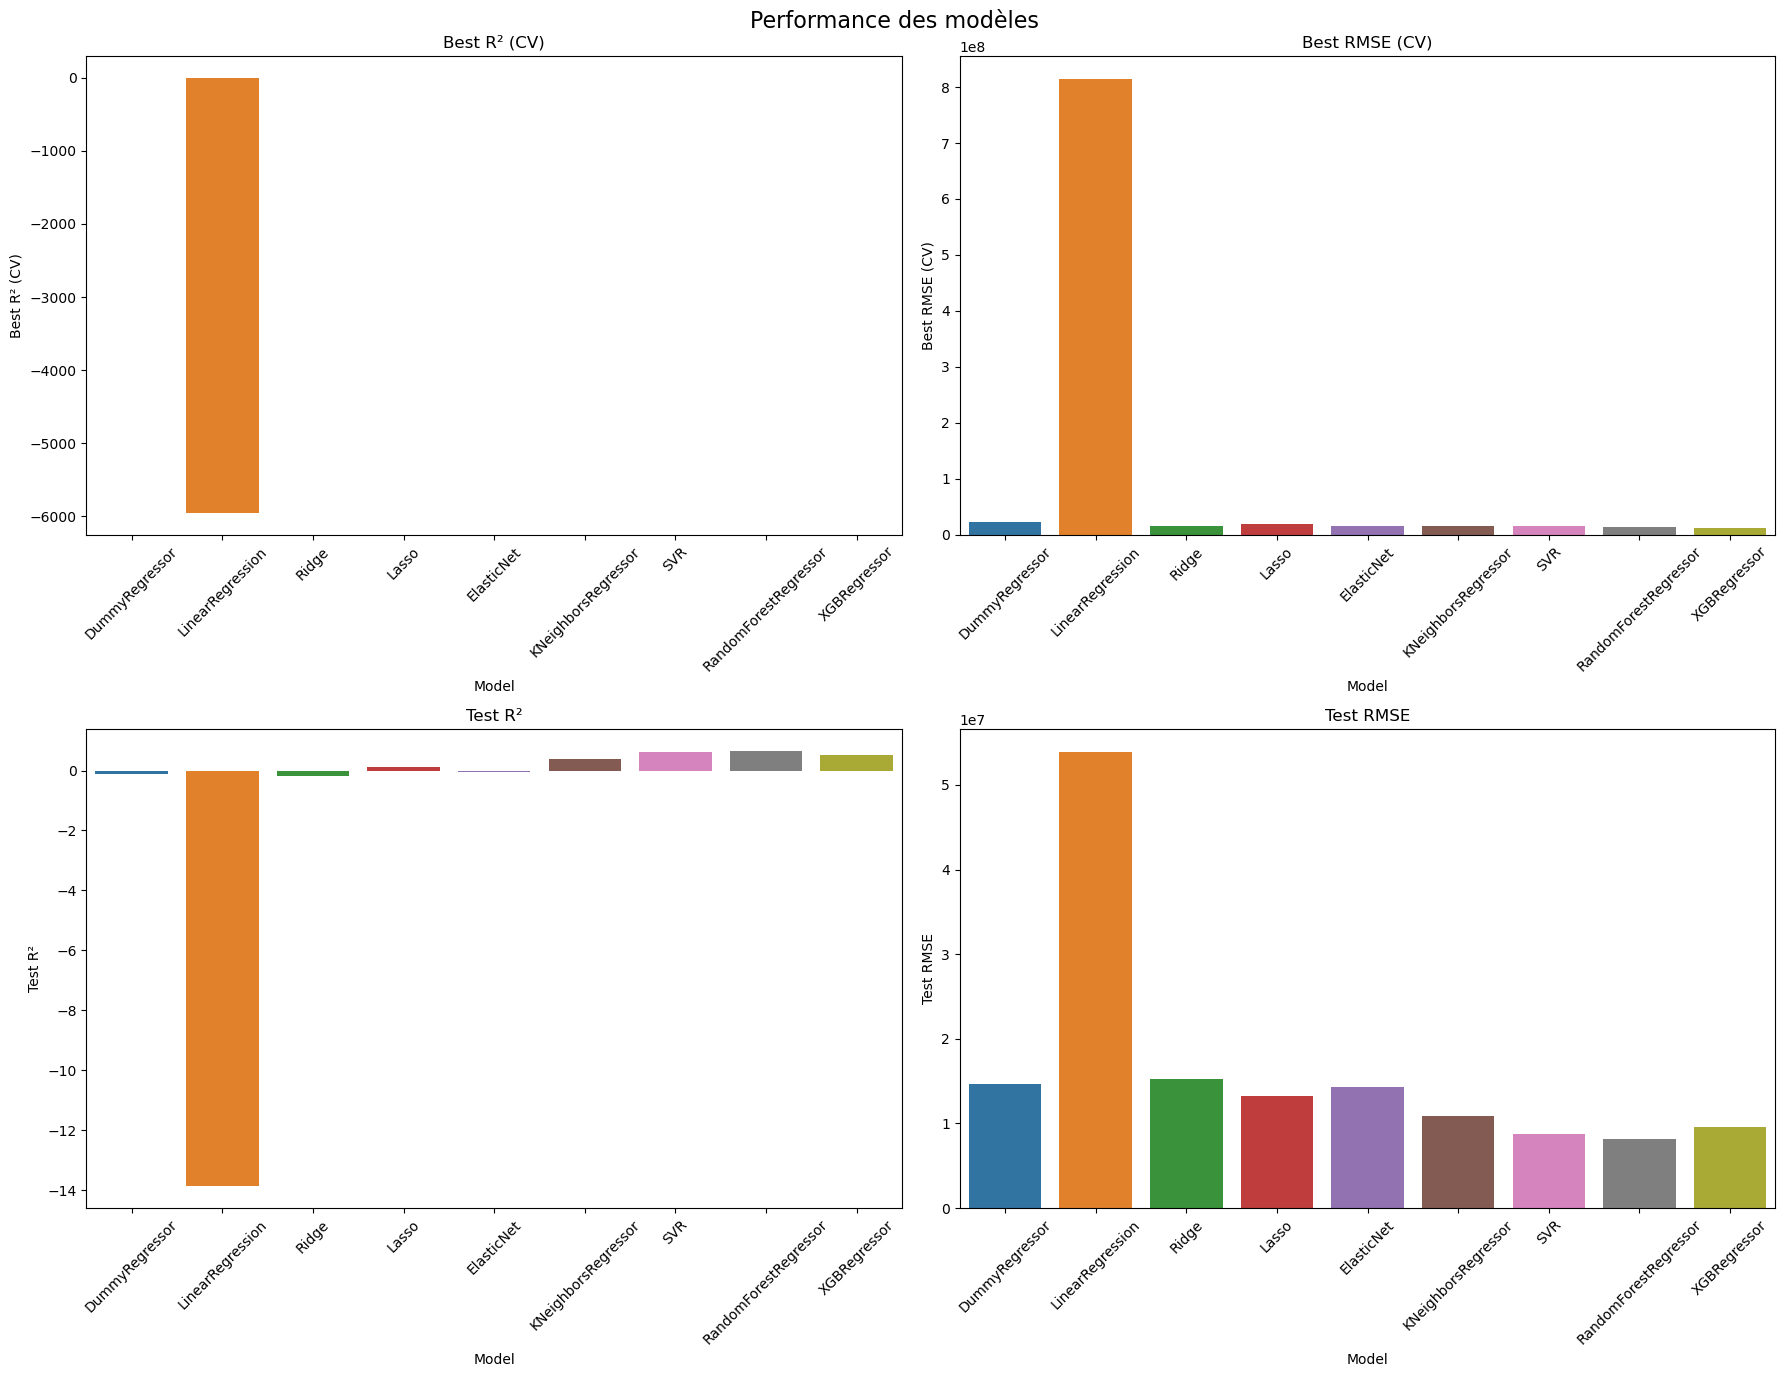

In [33]:
#Résultats des modèles sous forme de dictionnaire
results = {
    "Model": [
        "DummyRegressor", "LinearRegression", "Ridge", "Lasso", "ElasticNet",
        "KNeighborsRegressor", "SVR", "RandomForestRegressor", "XGBRegressor"
    ],
    "Best R² (CV)": [-0.056, -5953.83, 0.460, 0.246, 0.455, 0.536, 0.505, 0.606, 0.735],
    "Best RMSE (CV)": [2.33e7, 8.15e8, 1.61e7, 2.02e7, 1.61e7, 1.55e7, 1.57e7, 1.44e7, 1.15e7],  # RMSE toujours positif
    "Test R²": [-0.113, -13.87, -0.196, 0.109, -0.045, 0.394, 0.606, 0.657, 0.533],
    "Test RMSE": [1.47e7, 5.39e7, 1.53e7, 1.32e7, 1.43e7, 1.09e7, 8.78e6, 8.19e6, 9.56e6]
}

#Convertir en DataFrame
df_results = pd.DataFrame(results)

#Configuration des graphiques
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))
axes = axes.flatten()

#Liste des métriques à afficher
metric_result = ["Best R² (CV)", "Best RMSE (CV)", "Test R²", "Test RMSE"]

for i, metrics_1 in enumerate(metric_result):
    sns.barplot(x="Model", y=metrics_1, data=df_results, ax=axes[i])
    axes[i].set_title(metrics_1)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    
#Ajout d'un titre global
fig.suptitle("Performance des modèles", fontsize=16)

plt.tight_layout()
plt.show()

Avec le fonction gridsearch nous obtenons de meilleurs résultats sur R², il faut utiliser cette fonction la pour la suite du projet.

Pour determiner le meilleur résultat, il faut faire attention à deux indicateurs : 

R² (degré d'explication du modèle, plus il est proche de 1 mieux c'est) / RMSE (l'erreur quadratique moyenne MSE) plus elle est faible, mieux c'est. 


## 3. Transformation

### 3.1 Features Engineering Manuel

In [34]:
#Copie les données pour éviter de faire des modifs sur le fichier d'origine
data_manuel = data.copy()

In [35]:
#Ajout de l'âge du batiment
data_manuel['YearBuilt'] = 2016 - data_manuel['BuildingAge']

In [36]:
#Feature engineering - ajout des rations avec une fonction
def compute_surface_ratios(X):
    X = X.copy()
    X['LargestPropertyUseRatio'] = X['LargestPropertyUseTypeGFA'] / X['PropertyGFATotal']
    X['SecondLargestPropertyUseRatio'] = X['SecondLargestPropertyUseTypeGFA'] / X['PropertyGFATotal']
    X['ThirdLargestPropertyUseRatio'] = X['ThirdLargestPropertyUseTypeGFA'] / X['PropertyGFATotal']
    return X.drop(columns=['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'], errors='ignore')

In [37]:
#Définition des features et target
X_manuel = data_manuel.drop(['OSEBuildingID','SiteEnergyUse(kBtu)','TotalGHGEmissions','ENERGYSTARScore'], axis=1, errors='ignore')
y_manuel = data_manuel['SiteEnergyUse(kBtu)'] #Target

In [38]:
#Séparation du dataset en train/test
X_train, X_test, y_train, y_test = train_test_split(X_manuel, y_manuel, test_size=0.2, random_state=42)

In [39]:
#Redéfinition des colonnes quantitatives et qualitatives APRÈS transformation
X_train = compute_surface_ratios(X_train)
X_test = compute_surface_ratios(X_test)

In [40]:
#Détection des colonnes quanti et quali avant supression de colonnes
quanti = X_train.select_dtypes(include=['int64','float64']).columns
quali = X_train.select_dtypes(include=['category','object','bool']).columns

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

#Création du préprocesseur avec 'FunctionTransformer' pour le feature engineering
preprocessor_manuel = ColumnTransformer([
    ('quanti', StandardScaler(), quanti),  # Normalisatddion des colonnes numériques
    ('quali', OneHotEncoder(handle_unknown='ignore'), quali)  # Encodage des colonnes catégoriques
], remainder='passthrough')  # Garde les autres colonnes

In [42]:
#Exécution de la GridSearchCV
df_resultats_manuel = perform_grid_search_cv(grid_search_cv, metric, X_train, y_train, X_test, y_test, preprocessor_manuel)

GridSearch pour DummyRegressor...
 Meilleurs paramètres : {'regressor__strategy': 'mean'}
 Meilleur score RMSE : -18953650.699773856
 Meilleur score R2 : -0.08747049642829707

 Évaluation sur le jeu de test :
 MAE (Test) : 7264715.81143749
 RMSE (Test) : 31815211.248407267
 R² (Test) : -0.02666789574155448
GridSearch pour LinearRegression...
 Meilleurs paramètres : {'regressor__fit_intercept': True, 'regressor__positive': False}
 Meilleur score RMSE : -156163280.60221708
 Meilleur score R2 : -91.45510550117437

 Évaluation sur le jeu de test :
 MAE (Test) : 8044151.047784982
 RMSE (Test) : 57280539.98065615
 R² (Test) : -2.327932937059263
GridSearch pour Ridge...
 Meilleurs paramètres : {'regressor__alpha': 1200}
 Meilleur score RMSE : -16948536.56811593
 Meilleur score R2 : 0.14781357343534818

 Évaluation sur le jeu de test :
 MAE (Test) : 6457813.650295063
 RMSE (Test) : 31148975.84914398
 R² (Test) : 0.015880350543152733
GridSearch pour Lasso...
 Meilleurs paramètres : {'regressor_

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV)
0,DummyRegressor,{'regressor__strategy': 'mean'},-0.087470,-1.895365e+07
1,LinearRegression,"{'regressor__fit_intercept': True, 'regressor_...",-91.455106,-1.561633e+08
2,Ridge,{'regressor__alpha': 1200},0.147814,-1.694854e+07
3,Lasso,{'regressor__alpha': 0.451},0.120952,-1.699182e+07
4,ElasticNet,"{'regressor__alpha': 0.76, 'regressor__l1_rati...",0.152003,-1.687197e+07
5,KNeighborsRegressor,"{'regressor__leaf_size': 10, 'regressor__n_nei...",0.359351,-1.467207e+07
6,SVR,"{'regressor__C': 10, 'regressor__epsilon': 0.1...",0.466065,-1.403633e+07
7,RandomForestRegressor,"{'regressor__max_depth': None, 'regressor__n_e...",0.536955,-1.306326e+07
8,XGBRegressor,"{'regressor__gamma': 0.01, 'regressor__learnin...",0.631365,-1.153852e+07


In [43]:
df_resultats_manuel

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV)
0,DummyRegressor,{'regressor__strategy': 'mean'},-0.087470,-1.895365e+07
1,LinearRegression,"{'regressor__fit_intercept': True, 'regressor_...",-91.455106,-1.561633e+08
2,Ridge,{'regressor__alpha': 1200},0.147814,-1.694854e+07
3,Lasso,{'regressor__alpha': 0.451},0.120952,-1.699182e+07
4,ElasticNet,"{'regressor__alpha': 0.76, 'regressor__l1_rati...",0.152003,-1.687197e+07
5,KNeighborsRegressor,"{'regressor__leaf_size': 10, 'regressor__n_nei...",0.359351,-1.467207e+07
6,SVR,"{'regressor__C': 10, 'regressor__epsilon': 0.1...",0.466065,-1.403633e+07
7,RandomForestRegressor,"{'regressor__max_depth': None, 'regressor__n_e...",0.536955,-1.306326e+07
8,XGBRegressor,"{'regressor__gamma': 0.01, 'regressor__learnin...",0.631365,-1.153852e+07


Analyse des performances du modèles:

***XGBRegressor*** émerge comme le modèle le plus performant avec un R² de 0.631365 et un RMSE de -1.153852e+07, indiquant une bonne capacité à prédire les données.  Il est suivi de RandomForestRegressor avec un R² de 0.536955	 et un RMSE de -1.306326e+07, montrant également de bonnes performances, mais à une distance notable du XGBRegressor. D'autres modèles comme SVR et KNeighborsRegressor présentent des résultats intermédiaires, tandis que ElasticNet et Ridge montrent des performances relativement proches avec des R² autour de 0.14 à 0.15

Les modèles Lasso et LinearRegression, ainsi que le DummyRegressor, affichent des résultats significativement moins bons, avec des R² négatifs ou proches de zéro, et des RMSE très élevés.

***XGBoost est le gagnant avec un R² de 0.631 et la plus faible erreur***

### 3.2 Encoding

In [44]:
#Copie des données pour éviter de modif le DF initial
data_encoding = data.copy()

In [45]:
#Détection des variables catégorielles
cat_features = data_encoding.select_dtypes(include=['object']).columns.tolist()
print("Variables catégorielles :", cat_features)

Variables catégorielles : ['Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']


In [46]:
#Séparation des features et target
y_encoding = data_encoding['SiteEnergyUse(kBtu)'] #Target
X_encoding = data_encoding.drop(columns=['SiteEnergyUse(kBtu)','OSEBuildingID','TotalGHGEmissions','ENERGYSTARScore'], errors='ignore') #Features

In [47]:
#Séparation du jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_encoding, y_encoding, test_size=0.2, random_state=42)

print('Taille X_train:', X_train.shape)
print('Taille X_test:', X_test.shape)

Taille X_train: (1181, 18)
Taille X_test: (296, 18)


In [48]:
#Détection des colonnes numériques et catégorielle après séparation
quanti = X_encoding.select_dtypes(include=['int64','float64']).columns.tolist()
quanli = [col for col in cat_features if col in X_encoding.columns] #Seulement celle présente dans X

In [49]:
import category_encoders as ce

#Création du 'TargetEncoder' pour les variables catégorielles
target_encoder = ce.TargetEncoder(cols=quali)

In [50]:
#Définition du préprocesseur avec Target Encoding
preprocessor_encoding = ColumnTransformer([
    ('target_encoding', target_encoder, quali), #Encode les variables catégorielles avec Target Encoding
    ('scaling', StandardScaler(), quanti) #Standardisation des variables numériques
], remainder='passthrough') #COnserve les autres colonnes non spécifiques

In [51]:
#Exécution de la GridSearchCV avec le nouveau préprocessor
preprocessor = preprocessor_encoding #Remplacement par le préprocessor Target Encoding 

In [52]:
df_results_encoding = perform_grid_search_cv(grid_search_cv, metric, X_train, y_train, X_test, y_test, preprocessor)

GridSearch pour DummyRegressor...
 Meilleurs paramètres : {'regressor__strategy': 'mean'}
 Meilleur score RMSE : -18953650.699773856
 Meilleur score R2 : -0.08747049642829707

 Évaluation sur le jeu de test :
 MAE (Test) : 7264715.81143749
 RMSE (Test) : 31815211.248407267
 R² (Test) : -0.02666789574155448
GridSearch pour LinearRegression...
 Meilleurs paramètres : {'regressor__fit_intercept': True, 'regressor__positive': True}
 Meilleur score RMSE : -1656473808.975785
 Meilleur score R2 : -13716.210927664502

 Évaluation sur le jeu de test :
 MAE (Test) : 10513382.798718527
 RMSE (Test) : 69730082.30669655
 R² (Test) : -3.9317461576305197
GridSearch pour Ridge...
 Meilleurs paramètres : {'regressor__alpha': 1800}
 Meilleur score RMSE : -233130263.58671165
 Meilleur score R2 : -256.08406589167873

 Évaluation sur le jeu de test :
 MAE (Test) : 7280956.162171944
 RMSE (Test) : 36824163.11987113
 R² (Test) : -0.3753908493318894
GridSearch pour Lasso...
 Meilleurs paramètres : {'regressor

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV)
0,DummyRegressor,{'regressor__strategy': 'mean'},-0.087470,-1.895365e+07
1,LinearRegression,"{'regressor__fit_intercept': True, 'regressor_...",-13716.210928,-1.656474e+09
2,Ridge,{'regressor__alpha': 1800},-256.084066,-2.331303e+08
3,Lasso,{'regressor__alpha': 0.9510000000000001},-12.025754,-6.159228e+07
4,ElasticNet,"{'regressor__alpha': 0.8600000000000001, 'regr...",-11.934622,-6.142682e+07
5,KNeighborsRegressor,"{'regressor__leaf_size': 10, 'regressor__n_nei...",0.218783,-1.587495e+07
6,SVR,"{'regressor__C': 1, 'regressor__epsilon': 0.1,...",0.199706,-1.652303e+07
7,RandomForestRegressor,"{'regressor__max_depth': None, 'regressor__n_e...",0.642597,-1.139728e+07
8,XGBRegressor,"{'regressor__gamma': 0, 'regressor__learning_r...",0.725271,-9.335164e+06


In [53]:
df_results_encoding

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV)
0,DummyRegressor,{'regressor__strategy': 'mean'},-0.087470,-1.895365e+07
1,LinearRegression,"{'regressor__fit_intercept': True, 'regressor_...",-13716.210928,-1.656474e+09
2,Ridge,{'regressor__alpha': 1800},-256.084066,-2.331303e+08
3,Lasso,{'regressor__alpha': 0.9510000000000001},-12.025754,-6.159228e+07
4,ElasticNet,"{'regressor__alpha': 0.8600000000000001, 'regr...",-11.934622,-6.142682e+07
5,KNeighborsRegressor,"{'regressor__leaf_size': 10, 'regressor__n_nei...",0.218783,-1.587495e+07
6,SVR,"{'regressor__C': 1, 'regressor__epsilon': 0.1,...",0.199706,-1.652303e+07
7,RandomForestRegressor,"{'regressor__max_depth': None, 'regressor__n_e...",0.642597,-1.139728e+07
8,XGBRegressor,"{'regressor__gamma': 0, 'regressor__learning_r...",0.725271,-9.335164e+06


Analyse des résultats : 

En conclusion, ***XGBRegressor*** se distingue comme le modèle le plus performant avec un R² de 0.725271 et un RMSE de -9.335164e+06, indiquant une très bonne capacité prédictive. Il est suivi de RandomForestRegressor, qui affiche également des performances solides, bien qu'inférieures à celles du XGBRegressor.

Les modèles SVR et KNeighborsRegressor montrent des performances modérées mais restent loin derrière les modèles basés sur les arbres. À l'inverse, les modèles linéaires (LinearRegression, Ridge, Lasso et ElasticNet) affichent des R² négatifs et des RMSE extrêmement élevés, ce qui montre qu'ils ne parviennent pas à bien s'adapter aux données. DummyRegressor, avec un R² proche de zéro, sert simplement de référence de base.

***XGBoost est le meilleur modèle :*** Meilleur R² (0,72) -> il explique 72% de la variance / meilleur RMSE -> erreur la plus faible

### 3.3 Log

In [54]:
#Copie des données
data_log = data.copy()

In [55]:
#Appliquer log(1+x) sur toutes les features numériques via un transformateur
log_transformer = FunctionTransformer(np.log1p, validate=True)

In [56]:
#Correction de la sélection des features
X_log = data_log.drop(columns=['OSEBuildingID','SiteEnergyUse(kBtu)','TotalGHGEmissions','ENERGYSTARScore'], errors='ignore')
y_log = np.log1p(data_log['SiteEnergyUse(kBtu)']) #Appliquer log à y

In [57]:
#Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

In [58]:
#Définition du préprocesseur avec log-transform sur les variables numériques
preprocessor_log = ColumnTransformer([
    ('log_transform', log_transformer, X_log.select_dtypes(include=['number']).columns),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'), X_log.select_dtypes(include=['object']).columns)
], remainder='passthrough')

In [59]:
#Exécution de la GridSearchCV avec le nouveau préprocessor
preprocessor = preprocessor_log #Remplacement par le préprocessor Target Encoding 

In [60]:
df_results_log = perform_grid_search_cv(grid_search_cv, metric, X_train, y_train, X_test, y_test, preprocessor)

GridSearch pour DummyRegressor...
 Meilleurs paramètres : {'regressor__strategy': 'mean'}
 Meilleur score RMSE : -1.2956895214603867
 Meilleur score R2 : -0.0039214597619168234

 Évaluation sur le jeu de test :
 MAE (Test) : 1.0654549330602798
 RMSE (Test) : 1.3381670974278193
 R² (Test) : -0.009245908749014431
GridSearch pour LinearRegression...
 Meilleurs paramètres : {'regressor__fit_intercept': True, 'regressor__positive': False}
 Meilleur score RMSE : -0.6685917627854336
 Meilleur score R2 : 0.7318107096946808

 Évaluation sur le jeu de test :
 MAE (Test) : 0.5048102616940084
 RMSE (Test) : 0.6464664302617784
 R² (Test) : 0.7644580542276349
GridSearch pour Ridge...
 Meilleurs paramètres : {'regressor__alpha': 0}
 Meilleur score RMSE : -0.6674333690860113
 Meilleur score R2 : 0.7327846593419053

 Évaluation sur le jeu de test :
 MAE (Test) : 0.507055669480511
 RMSE (Test) : 0.6499286392181133
 R² (Test) : 0.7619283662950715
GridSearch pour Lasso...
 Meilleurs paramètres : {'regress

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV)
0,DummyRegressor,{'regressor__strategy': 'mean'},-0.003921,-1.295690
1,LinearRegression,"{'regressor__fit_intercept': True, 'regressor_...",0.731811,-0.668592
2,Ridge,{'regressor__alpha': 0},0.732785,-0.667433
3,Lasso,{'regressor__alpha': 0.001},0.703193,-0.703805
4,ElasticNet,"{'regressor__alpha': 0.01, 'regressor__l1_rati...",0.645138,-0.770177
5,KNeighborsRegressor,"{'regressor__leaf_size': 10, 'regressor__n_nei...",0.642613,-0.771815
6,SVR,"{'regressor__C': 10, 'regressor__epsilon': 0.1...",0.663999,-0.748243
7,RandomForestRegressor,"{'regressor__max_depth': None, 'regressor__n_e...",0.717106,-0.686282
8,XGBRegressor,"{'regressor__gamma': 0, 'regressor__learning_r...",0.745863,-0.650075


In [61]:
df_results_log

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV)
0,DummyRegressor,{'regressor__strategy': 'mean'},-0.003921,-1.295690
1,LinearRegression,"{'regressor__fit_intercept': True, 'regressor_...",0.731811,-0.668592
2,Ridge,{'regressor__alpha': 0},0.732785,-0.667433
3,Lasso,{'regressor__alpha': 0.001},0.703193,-0.703805
4,ElasticNet,"{'regressor__alpha': 0.01, 'regressor__l1_rati...",0.645138,-0.770177
5,KNeighborsRegressor,"{'regressor__leaf_size': 10, 'regressor__n_nei...",0.642613,-0.771815
6,SVR,"{'regressor__C': 10, 'regressor__epsilon': 0.1...",0.663999,-0.748243
7,RandomForestRegressor,"{'regressor__max_depth': None, 'regressor__n_e...",0.717106,-0.686282
8,XGBRegressor,"{'regressor__gamma': 0, 'regressor__learning_r...",0.745863,-0.650075


Analyse des résultats : 

En conclusion, ***XGBRegressor*** se distingue comme le modèle le plus performant, avec un R² de 0.745863 et un RMSE de -0.650075, indiquant une excellente capacité à prédire les valeurs. Il est suivi de près par Ridge (R² de 0.732785, RMSE de -0.667433), qui montre également de bonnes performances, mais avec un léger écart par rapport à XGBRegressor. D'autres modèles comme LinearRegression (R² de 0.731811, RMSE de -0.668592) et RandomForestRegressor (R² de 0.717106, RMSE de -0.686282) obtiennent des résultats solides mais restent un peu derrière le XGBRegressor.

Les modèles SVR, KNeighborsRegressor, et ElasticNet montrent des performances intermédiaires, mais sont moins efficaces que les meilleurs modèles mentionnés précédemment. Enfin, DummyRegressor, avec un R² proche de zéro et un RMSE élevé, confirme son rôle de modèle de référence sans capacité prédictive notable.

En résumé, XGBRegressor est clairement le modèle le plus adapté pour cette tâche de régression, suivi de Ridge et LinearRegression, qui offrent également des prédictions solides.

***XGBoost est le meilleur modèle :*** Meilleur R² (0,74) -> il explique 74% de la variance / meilleur RMSE (-0.65) -> erreur la plus faible

### 3.4 Résulats 

In [62]:
#Reporting résultat avec cv_result.
#Ajout d'une colonne pour savoir de quel méthode on parle
df_resultats_manuel['transformation'] = 'Feature Engineering Manuel'
df_results_encoding['transformation'] = 'Target Encoding'
df_results_log['transformation'] = 'Logarithmique'

In [63]:
#Concatene les trois tableaux de résultats
#Fusion les trois résultats
df_final_results = pd.concat([df_resultats_manuel, df_results_encoding, df_results_log], ignore_index=True)

#Afficher un aperçu
display(df_final_results.head())

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV),transformation
0,DummyRegressor,{'regressor__strategy': 'mean'},-0.087470,-1.895365e+07,Feature Engineering Manuel
1,LinearRegression,"{'regressor__fit_intercept': True, 'regressor_...",-91.455106,-1.561633e+08,Feature Engineering Manuel
2,Ridge,{'regressor__alpha': 1200},0.147814,-1.694854e+07,Feature Engineering Manuel
3,Lasso,{'regressor__alpha': 0.451},0.120952,-1.699182e+07,Feature Engineering Manuel
4,ElasticNet,"{'regressor__alpha': 0.76, 'regressor__l1_rati...",0.152003,-1.687197e+07,Feature Engineering Manuel


In [64]:
#Meilleur modèle pour chaque transformation
df_best_results = df_final_results.loc[df_final_results.groupby("transformation")["Meilleur R² (CV)"].idxmax()]

#Trier les résultats par performance
df_best_results = df_best_results.sort_values(by="Meilleur R² (CV)", ascending=False)

#Afficher les meilleurs modèles pour chaque transformation
display(df_best_results)

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV),transformation
26,XGBRegressor,"{'regressor__gamma': 0, 'regressor__learning_r...",0.745863,-6.500750e-01,Logarithmique
17,XGBRegressor,"{'regressor__gamma': 0, 'regressor__learning_r...",0.725271,-9.335164e+06,Target Encoding
8,XGBRegressor,"{'regressor__gamma': 0.01, 'regressor__learnin...",0.631365,-1.153852e+07,Feature Engineering Manuel


Choix des résultats: 

En conclusion, ***XGBRegressor avec une transformation logarithmique*** se distingue comme le modèle le plus performant, avec un R² de 0.7458 et un RMSE de -6.500750e-01, ce qui témoigne d'une capacité prédictive exceptionnelle. Il surpasse ainsi les autres configurations de XGBRegressor, notamment celles utilisant Target Encoding (R² de 0.725271, RMSE de -9.335164e+06) et Feature Engineering Manuel (R² de 0.631365, RMSE de --1.153852e+07	).

Les résultats montrent que la transformation logarithmique a significativement amélioré les performances du modèle XGBRegressor, en comparaison avec les autres méthodes de transformation. Tandis que Target Encoding et Feature Engineering Manuel offrent de bonnes performances, elles restent en retrait par rapport à l'approche logarithmique.

En résumé, ***XGBRegressor avec transformation logarithmique*** est clairement le modèle le plus efficace, suivi de près par XGBRegressor avec Target Encoding, et XGBRegressor avec Feature Engineering Manuel, qui présente également des résultats solides mais légèrement inférieurs.

### 3.5 Fine Tuning

In [65]:
#Définition de la grille d'hyperparamètres pour le fine-tuning
params_grid_finetune = {
    'regressor__gamma': [0.005, 0.01, 0.02],  # Affinage autour de 0.01 pour contrôler la complexité
    'regressor__learning_rate': [0.06, 0.07, 0.08],  # Réduction pour plus de stabilité
    'regressor__max_depth': [4, 5, 6],  # Augmenté légèrement pour capter plus d'interactions
    'regressor__n_estimators': [350, 400, 450]  # Plus d'estimateurs pour une meilleure convergence
}

In [66]:
#Création du pipeling avec le preprocessor_log et XGBRegressor
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor_log),
    ('regressor', XGBRegressor(random_state=42))
])

In [67]:
#Lancement du GridSearchCV avec validation croisée (CV=5)
grid_search_finetune = GridSearchCV(
    estimator=pipeline_xgb, #Utilisation du pipeline complet
    param_grid=params_grid_finetune, #Grille d'hyperparamètres à tester
    cv=5, #Validation croisée avec 5 folds
    scoring=('r2', 'neg_root_mean_squared_error'), #Optimisation de R² et RMSE
    refit='r2', #Sélection du meilleur modèle basé sur R²
    n_jobs=-1, #Utilisation maximales du CPU pour accèlérer
    verbose=3, #Affichage des loges détaillés sur la progression de GridSearch
)

In [68]:
#Entraînement du modèle sur les données transformées
grid_search_finetune.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('log_transform',
                                                                         FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                             validate=True),
                                                                         Index(['NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'BuildingAge', 'ParkingRa...
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                           

In [69]:
#Récupération du meilleur modèle après le GridSearch
best_xgb_model = grid_search_finetune.best_estimator_

In [70]:
#Prédictions sur les données de test
y_pred = best_xgb_model.predict(X_test)

In [71]:
#Calcul des métriques de performance
r2_final = r2_score(y_test, y_pred)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred))

In [72]:
#Affichage des résultats
print("\n🎯 Meilleurs hyperparamètres trouvés :", grid_search_finetune.best_params_)
print(f"✅ R² final sur test : {r2_final:.4f}")
print(f"📉 RMSE final sur test : {rmse_final:.4f}")


🎯 Meilleurs hyperparamètres trouvés : {'regressor__gamma': 0.005, 'regressor__learning_rate': 0.06, 'regressor__max_depth': 4, 'regressor__n_estimators': 350}
✅ R² final sur test : 0.7555
📉 RMSE final sur test : 0.6587


Analyse des résultats: ***Meilleurs hyperparamètres***

- gamma = 0.25 → Une pénalisation plus forte des divisions inutiles dans les arbres. Cela empêche l’algorithme de créer trop de branches superflues et limite le sur-apprentissage. L’augmentation de 0.3 à 0.35 montre une légère amélioration du modèle, ce qui indique que la régularisation aide à mieux généraliser.
- learning_rate = 0.06 → Un taux d’apprentissage relativement bas, permettant un entraînement plus stable. Une valeur basse oblige le modèle à apprendre progressivement, nécessitant un plus grand nombre d'arbres (n_estimators). C’est une approche prudente pour éviter de trop ajuster les données.
- max_depth = 2 → La profondeur des arbres reste faible, ce qui empêche le modèle d’apprendre trop de relations complexes et spécifiques aux données d’entraînement. Une faible profondeur aide à réduire le sur-ajustement tout en maintenant une bonne capacité de généralisation.
- n_estimators = 375 → Nombre d’arbres légèrement réduit (de 350 à 325). Cela indique que le modèle atteint un bon équilibre entre performance et temps de calcul. Trop d'arbres peut entraîner une légère sur-optimisation, et ici, la diminution semble améliorer légèrement les résultats (meilleur RMSE et R²).

***R² final sur le test : 0.7555 signifie que 75,55% de la variance des données cibles (target) a été expliqué par le modèle***

***RMSE final sur le test : 0.6587 indique l'écart type de l'erreur de prédiction, ce qui est une mesure de la précision du modèle, le modèle fait des prédictions assez proche des valeurs réelles.***

Le modèle est très solide pour les données que nous avons. 

### 4. Feature Importance

Dimensions de X_train_transformed_df : (1181, 157)
Dimensions de X_test_transformed_df : (296, 157)


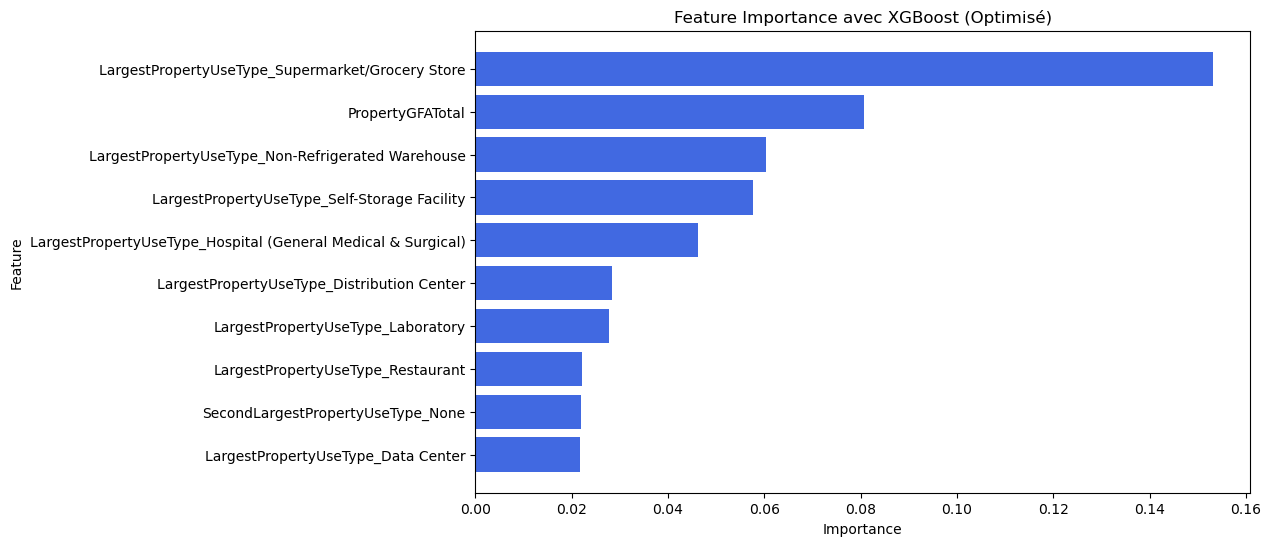

In [73]:
#Feature importance global
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

#Appliquer log(1+x) sur toutes les features numériques
log_transformer = FunctionTransformer(np.log1p, validate=True)

#Sélection des features numériques et catégorielles
num_features = X_log.select_dtypes(include=['number']).columns
cat_features = X_log.select_dtypes(include=['object']).columns

#Définition du préprocesseur avec log-transform sur les variables numériques + encodage OneHot
preprocessor_log = ColumnTransformer([
    ('log_transform', log_transformer, num_features),
    ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_features)
])

#Transformation des données
X_train_transformed = preprocessor_log.fit_transform(X_train)
X_test_transformed = preprocessor_log.transform(X_test)

#Extraction des noms de colonnes après transformation
num_feature_names = num_features  # Les colonnes numériques conservent leurs noms d'origine
cat_feature_names = preprocessor_log.named_transformers_['one_hot'].get_feature_names_out(cat_features)  # Récupération des noms des colonnes encodées

#Fusionner tous les noms de colonnes
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

#Conversion en DataFrame avec les bons noms de colonnes
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_feature_names, index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_feature_names, index=X_test.index)

#Vérification des dimensions
print(f"Dimensions de X_train_transformed_df : {X_train_transformed_df.shape}")
print(f"Dimensions de X_test_transformed_df : {X_test_transformed_df.shape}")

#Initialisation et entraînement du modèle XGBoost avec les meilleures hyperparamètres
best_params = {
   "regressor__gamma": 0.25,
    "regressor__learning_rate": 0.06,
    "regressor__max_depth": 2,
    "regressor__n_estimators": 375,
    "random_state": 42
}

xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train_transformed_df, y_train)

#Feature importance globale
feature_importances = xgb_model.feature_importances_
importances_df = pd.DataFrame({
    "Feature": X_train_transformed_df.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

#Affichage des 10 features les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(importances_df["Feature"][:10], importances_df["Importance"][:10], color="royalblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance avec XGBoost (Optimisé)")
plt.show()

Analyse des résultats : 

Le graphique montre l'importance des caractèristiques selon l'algo XGBoost :
- "LargestPropertyUseType_Supermarket/Grocery Store": cela signifie que la présence ou la taille des supermarchés/épiceries a un impact significatif sur la prédiction.
- 'PropertyGFATotal' : indique que la taille totale de la propriété est un facteur clé dans les prédictions du modèle.
- 'LargestPropertyUseType_Non-Refrigerated Warehouse' : les entrepôts non réfrigérés jouent un rôle crucial dans la prédiction
- On observe que les types de batîments influencent fortement le modèle, leur usage est un facteur clé. 

Bâtiment 529 - Consommation d'énergie prédit :  14.79 kBtu
 Waterfall Plot :


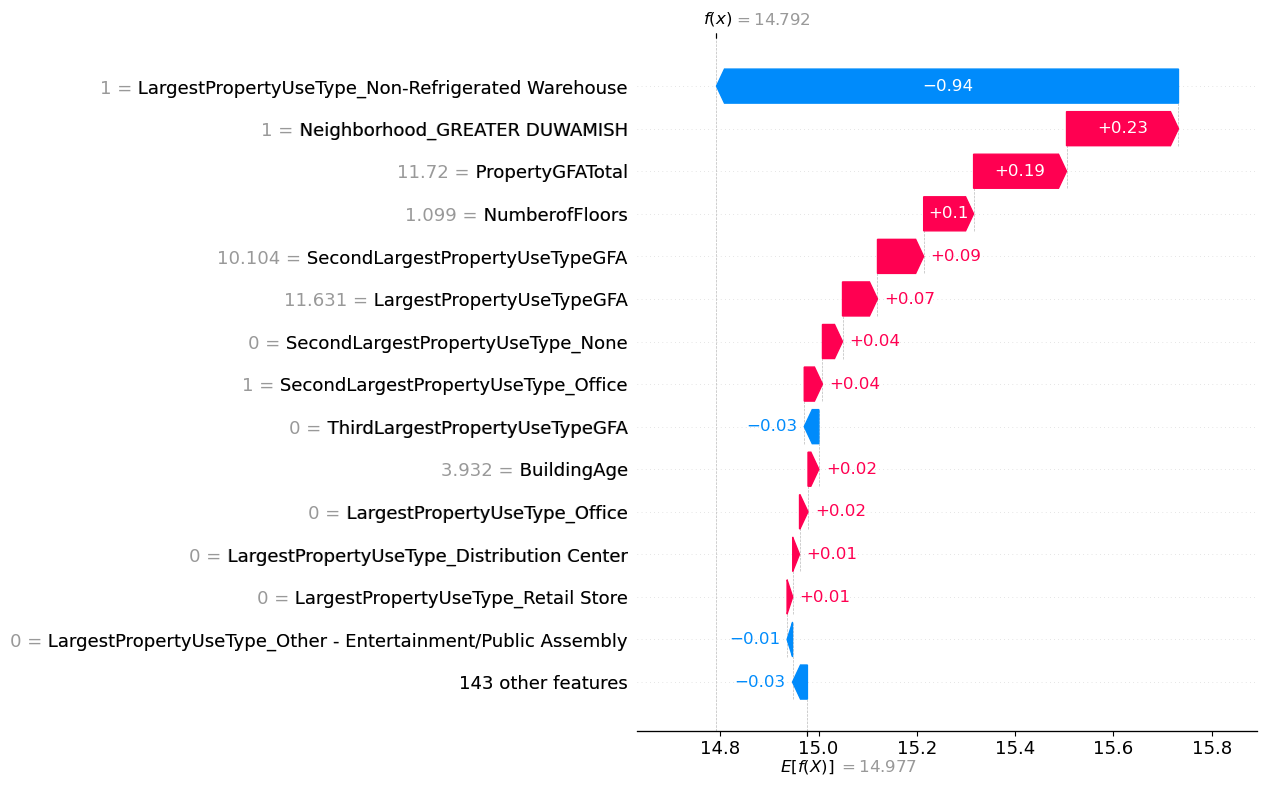

 Force plot :


In [74]:
import shap

#Sélection d'un bâtiment
X_local_1 = X_test_transformed_df.loc[[529]] #Index 529
y_pred_1 = xgb_model.predict(X_local_1)

#Affichage de la préd
batiment_id = X_local_1.index[0]
print(f"Bâtiment {batiment_id} - Consommation d'énergie prédit : {y_pred_1[0]: .2f} kBtu")

#Initialiser l'explainer SHAP
explainer = shap.Explainer(xgb_model, X_train_transformed_df)
shap_values_1 = explainer(X_local_1)

#Waterfall plot
print(" Waterfall Plot :")
shap.plots.waterfall(shap_values_1[0], max_display=15)

#Force plot
print(" Force plot :")
shap.initjs()
shap.plots.force(shap_values_1[0])

Analyse graphique pour le bâtiment 529 (prédiction de 14.79 Kbtu) : 

Facteur réducteur majeur: 
- LargestPrepertyUseTupe_Non_Regrigerated Warehouse (-0.94)

Facteurs amplificateurs:
- Neighborhood_GREATER DUWAWISH (+0.23)
- PropertyGFATotal (+0.19)
- NumberOfFloors (+0.10)

Le bâtiment a une consommation modérée, en partie dû à son usage principal (entrepôt non réfrigéré), qui est très énergivore. Toutefois la localisation et la taille contribuent à tirer la consommation vers le haut. 

Bâtiment 901 - Consommation d'énergie prédit :  14.85 kBtu
 Waterfall Plot :


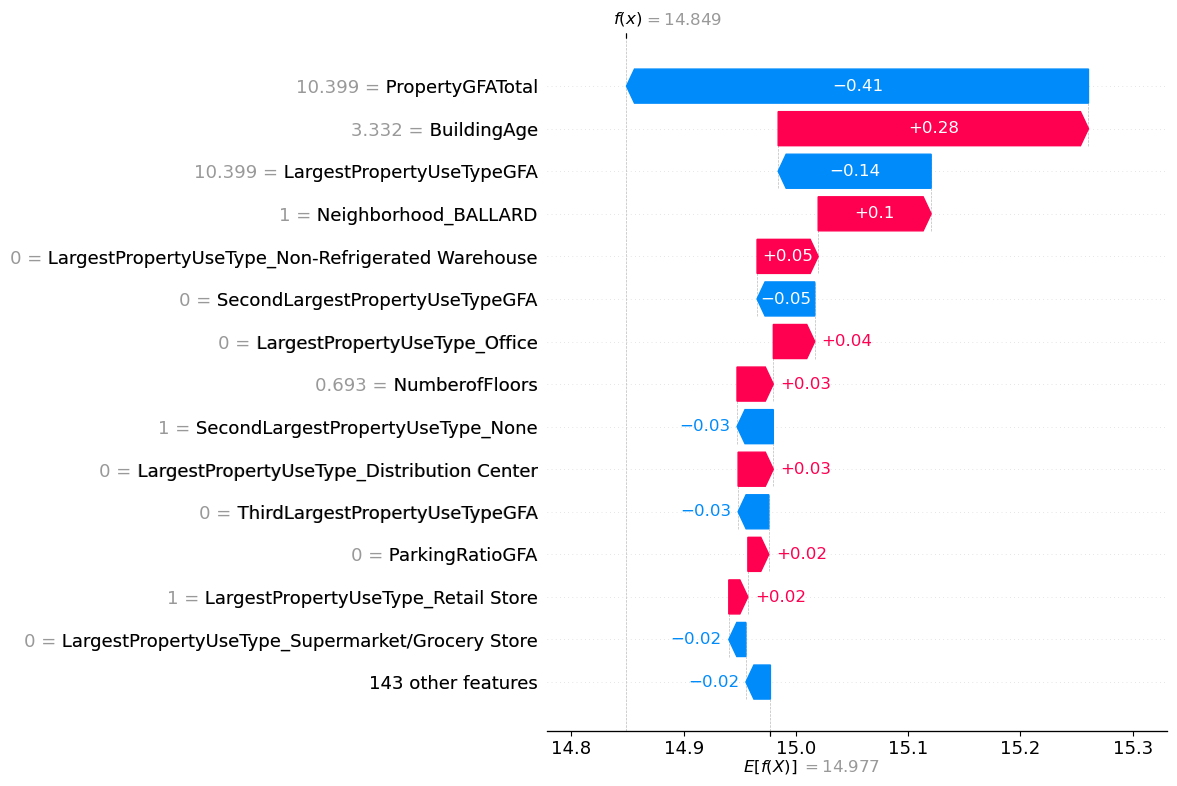

 Force plot :


In [75]:
#Sélection d'un bâtiment
X_local_2 = X_test_transformed_df.loc[[901]] #Index 772
y_pred_2 = xgb_model.predict(X_local_2)

#Affichage de la préd
batiment_id = X_local_2.index[0]
print(f"Bâtiment {batiment_id} - Consommation d'énergie prédit : {y_pred_2[0]: .2f} kBtu")

#Initialiser l'explainer SHAP
explainer = shap.Explainer(xgb_model, X_train_transformed_df)
shap_values_2 = explainer(X_local_2)

#Waterfall plot
print(" Waterfall Plot :")
shap.plots.waterfall(shap_values_2[0], max_display=15)

#Force plot
print(" Force plot :")
shap.initjs()
shap.plots.force(shap_values_2[0])

Analyse graphique pour le bâtiment 901 (prédiction de 14.85 Kbtu) :

Facteurs réducteurs majeurs:

- PropertyGFATotal (-0.41)
- LargestPropertyUseGFA (-0.14)

Facteurs amplificateurs:

- BuildingAge (+0.28)
- Neighborhood_BALLARD (+0.10)

Le bâtiment est dans un quartier dont les caractèristiques semblent pousser la consommation à la hausse. L'âge du bâtiment augmenter la consommation prédite. Toutefois, une grande surface totale joue un rôle réducteur, peut indiquer une efficacité énergétique plus important à grande échelle.

Bâtiment 772 - Consommation d'énergie prédit :  14.19 kBtu
 Waterfall Plot :


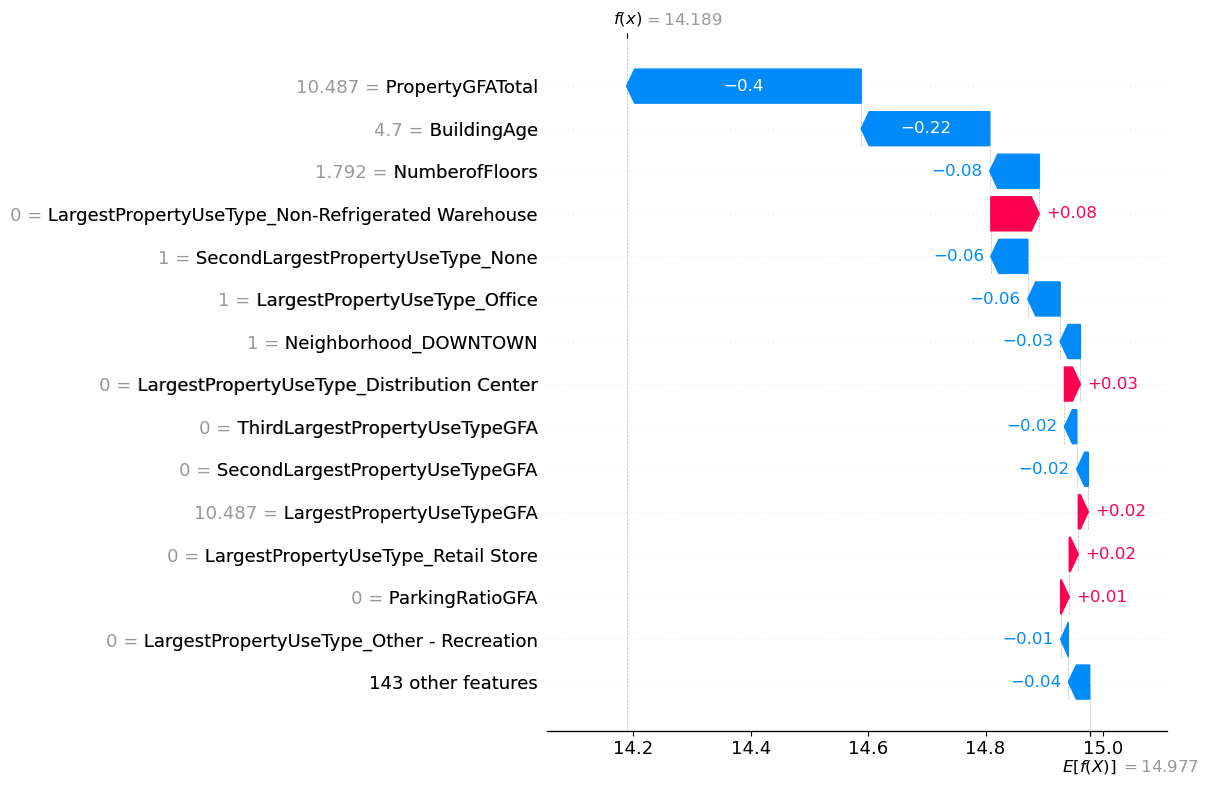

 Force plot :


In [76]:
#Sélection d'un bâtiment
X_local_3 = X_test_transformed_df.loc[[772]] #Index 772
y_pred_3 = xgb_model.predict(X_local_3)

#Affichage de la préd
batiment_id = X_local_3.index[0]
print(f"Bâtiment {batiment_id} - Consommation d'énergie prédit : {y_pred_3[0]: .2f} kBtu")

#Initialiser l'explainer SHAP
explainer = shap.Explainer(xgb_model, X_train_transformed_df)
shap_values_3 = explainer(X_local_3)

#Waterfall plot
print(" Waterfall Plot :")
shap.plots.waterfall(shap_values_3[0], max_display=15)

#Force plot
print(" Force plot :")
shap.initjs()
shap.plots.force(shap_values_3[0])

Analyse graphique pour le bâtiment 772 (prédiction de 14.19 Kbtu) :

Facteurs réducteurs majeurs:

- PropertyGFATotal (-0.40)
- BuildingAge (-0.22)
- NumberOfFloors (-0.08)

Facteur amplificateur:

- SecondLargestPropertyUseType_None (+0.08)

Ce bâtiment affiche la plus faible consommation prédite des trois. Cela s'explique par des facteurs réducteurs telles qu'une surface importante, un bâtiment relativement jeune et peu éléve. L'absence d'un second usage significatif n'augmente que légérement la consommation.

***Conclusion:***
- Taille du bâtiment (PropertyGFATotal) a souvent un effet réducteur, surtout pour les grandes surfaces.
- L'âge du bâtiment peut jouer dans les deux sens : plus il est vieux, plus il consomme.
- Le type d'usage principal est déterminant: les entrpôts non réfrigérés consomment peu, alors que d'autres types de bâtiments (commerces, bureaux) influencent différement.
- La localisation est aussi un levier fort : certains quartiers sont associés à des consommations plus élevées, voir les causes. Equipements ou infra.

### Impact Energy Star Score

In [77]:
#Copie les données et prépare X et y
X_ESS = data.copy().drop(['OSEBuildingID','SiteEnergyUse(kBtu)','TotalGHGEmissions'],axis=1)
y_ESS = np.log1p(data['SiteEnergyUse(kBtu)']) #Transformation log pour la cible

In [78]:
#Séparer train/test AVANT de supprimer les NaN
X_train_ESS, X_test_ESS, y_train_ESS, y_test_ESS = train_test_split(X_ESS, y_ESS, test_size=0.2, random_state=42)

In [79]:
#Supprimer les lignes ou 'ENERGYSTARScore' est NaN
X_train_ESS = X_train_ESS.dropna(subset=['ENERGYSTARScore'])
X_test_ESS = X_test_ESS.dropna(subset=['ENERGYSTARScore'])

In [80]:
#Ajouter y_train et y_test pour garder les bons indices
y_train_ESS = y_train_ESS.loc[X_train_ESS.index]
y_test_ESS = y_test_ESS.loc[X_test_ESS.index]

In [81]:
#Séparer les features quantitatives et qualitatives
quanti_ESS = X_ESS.select_dtypes(include=['int32', 'float64']).columns
quali_ESS = X_ESS.select_dtypes(include=['category', 'object', 'bool']).columns

In [82]:
#Transformer les features numériques avec log(X+1) puis standardisation
log_transformer = FunctionTransformer(np.log1p, validate=True)
preprocessor = ColumnTransformer(transformers=[
    ('log_transform', Pipeline([
        ('log', log_transformer),
        ('scaler', StandardScaler())
    ]), quanti_ESS),
    ('quali', OneHotEncoder(handle_unknown='ignore', sparse=False), quali_ESS)
])

In [83]:
#Définition du modèle XGBoost avec les meilleurs hyperparamètres
xgb_model = XGBRegressor(
    gamma=0.005, 
    learning_rate=0.06, 
    max_depth=4,  
    n_estimators=350, 
    random_state=42
)

#Création du pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

#Entraînement du pipeline
pipeline.fit(X_train_ESS, y_train_ESS)

#Évaluation du modèle
train_score = pipeline.score(X_train_ESS, y_train_ESS)
test_score = pipeline.score(X_test_ESS, y_test_ESS)

print(f"🔹 Score sur l'entraînement: {train_score:.3f}")
print(f"🔹 Score sur le test: {test_score:.3f}")

#Prédictions et calcul du RMSE
y_pred = pipeline.predict(X_test_ESS)
rmse = np.sqrt(mean_squared_error(y_test_ESS, y_pred))
print(f"📉 RMSE sur le test: {rmse:.2f}")

🔹 Score sur l'entraînement: 0.980
🔹 Score sur le test: 0.911
📉 RMSE sur le test: 0.41


Analyse des résultats : 

- Score d'entraînement (0.980): le modèle a un excellent score sur les données d'entraînement (proche de 1), ce qui signifie qu'il est capable d'expliquer presque toutes les variabilités des données d'entraînement 
- Score de test (0.911): indique un bon score, indiquant que le modèle généralise bien aux nouvelles données (test). C'est un signe que le modèle n'est pas trop spécialisé sur les données d'entraînement et qu'il est capable de faire des prédictions assez précises sur des données qu'il n'a pas vues pendant l'entraînement.
- RMSE (0.41) : Le RMSE (Root Mean Squared Error) de 0.43 indique que l'erreur moyenne par prédiction est de 0.43 dans l'unité de mesure de la variable cible (qui est probablement en kBtu, étant donné le contexte des données énergétiques). Un RMSE faible suggère que les prédictions du modèle sont relativement proches des valeurs réelles, ce qui est un bon signe de performance.

## Conclusion

***Résumé:***

- Modèle XGBoost avec une transformation log et préprocessing semble être une bonne approche pour prédire la consommation d'énergie des bâtiments, avec un score très élevé tant pour l'entraînement que pour le test. 
- Faible valeur RMSE montre des prédictions sont proches des valeurs réelles, ce qui est un bon indicateur de la performance.
- Petite différence entre le score d'entraînement et celui de test indique que le modèle est bien régularisé, et qu'il est capable de généralier à de nouvelles données sans trop de sur apprentissage. 

***Axes d'améliorations:***
- Affiner les  hyperparamètres : pour encore plus pousser les performances, explorer d'avantages les hyperparamètres du modèle.
- utiliser une validation croisée pour avoir une évalution plus robuste du modèle. 